In [1]:
import pandas as pd
import yfinance as yf
from tqdm import tqdm
import logging

logging.getLogger("yfinance").setLevel(logging.ERROR)


esg_csv = "../data/raw/sp500_esg_ceo_info-filtered.csv"  
esg_df = pd.read_csv(esg_csv)

print("Columnas CSV ESG:", esg_df.columns)
print("Número de tickers en CSV:", esg_df["Ticker"].nunique())

Columnas CSV ESG: Index(['Ticker', 'ESG Score', 'Governance Score', 'Environment Score',
       'Social Score', 'ESG Score Date', 'ESG Status', 'CEO Full Name',
       'CEO Gender', 'CEO Status', 'Year'],
      dtype='object')
Número de tickers en CSV: 426


In [2]:
tickers = esg_df["Ticker"].dropna().unique().tolist()[:400]

start_date = "2022-01-01"
end_date = "2023-12-31"

all_data = []


In [3]:
batch_size = 400
for i in range(0, len(tickers), batch_size):
    batch = tickers[i:i+batch_size]
    print(f"\nDescargando batch {i//batch_size + 1} de {len(tickers)//batch_size + 1}...")
    
    try:
        df = yf.download(
            batch,
            start=start_date,
            end=end_date,
            progress=False,
            auto_adjust=False  # 
        )
        
        # Pasamos de columnas multi-índice a columnas simples
        df = df.stack(level=1).reset_index()
        df.rename(columns={"level_1": "Ticker"}, inplace=True)
        
        all_data.append(df)
    except Exception as e:
        print(f"Error en batch {i//batch_size + 1}: {e}")



Descargando batch 1 de 2...


HTTP Error 404: 

8 Failed downloads:
['PEAK', 'HES', 'PXD', 'MRO', 'FLT', 'DFS', 'JNPR']: YFTzMissingError('possibly delisted; no timezone found')
['ANSS']: YFPricesMissingError('possibly delisted; no price data found  (1d 2022-01-01 -> 2023-12-31) (Yahoo error = "No data found, symbol may be delisted")')


In [4]:
# Unimos todos los datos financieros
fin_df = pd.concat(all_data, ignore_index=True)

print(f"\nDatos financieros: {fin_df.shape}")


Datos financieros: (196392, 8)


In [5]:
# Unimos con ESG (por ticker)
dataset_final = pd.merge(fin_df, esg_df, on="Ticker", how="inner")

In [6]:
# Creamos features de volatilidad para obtener 2 posibles targets (y) para nuestro futuro modelo predictivo

dataset_final["Daily_Return"] = dataset_final.groupby("Ticker")["Adj Close"].pct_change()
dataset_final["Daily_Volatility"] = (
    dataset_final.groupby("Ticker")["Daily_Return"]
    .rolling(5)
    .std()
    .reset_index(0, drop=True)
)

In [7]:
# Guardar CSV final
dataset_final.to_csv("dataset_final.csv", index=False)

print(f"\nDataset guardado como 'dataset_final.csv'")
print("Shape final:", dataset_final.shape)
print("\nPrimeras filas:\n", dataset_final.head())

dataset_final.info()


Dataset guardado como 'dataset_final.csv'
Shape final: (196392, 20)

Primeras filas:
         Date Ticker   Adj Close       Close        High         Low  \
0 2022-01-03      A  152.625916  156.479996  159.440002  153.929993   
1 2022-01-04      A  147.466232  151.190002  155.630005  149.699997   
2 2022-01-05      A  144.940002  148.600006  153.100006  148.529999   
3 2022-01-06      A  145.447189  149.119995  149.960007  145.580002   
4 2022-01-07      A  141.574951  145.149994  149.729996  145.089996   

         Open     Volume  ESG Score  Governance Score  Environment Score  \
0  159.000000  1606300.0      15.24              6.26               0.34   
1  155.490005  2234000.0      15.24              6.26               0.34   
2  150.830002  2370500.0      15.24              6.26               0.34   
3  148.850006  2298300.0      15.24              6.26               0.34   
4  149.119995  2058600.0      15.24              6.26               0.34   

   Social Score ESG Score Dat

EDA

In [8]:
dataset_final.head()

Date Ticker   Adj Close       Close        High         Low  \
0 2022-01-03      A  152.625916  156.479996  159.440002  153.929993   
1 2022-01-04      A  147.466232  151.190002  155.630005  149.699997   
2 2022-01-05      A  144.940002  148.600006  153.100006  148.529999   
3 2022-01-06      A  145.447189  149.119995  149.960007  145.580002   
4 2022-01-07      A  141.574951  145.149994  149.729996  145.089996   

         Open     Volume  ESG Score  Governance Score  Environment Score  \
0  159.000000  1606300.0      15.24              6.26               0.34   
1  155.490005  2234000.0      15.24              6.26               0.34   
2  150.830002  2370500.0      15.24              6.26               0.34   
3  148.850006  2298300.0      15.24              6.26               0.34   
4  149.119995  2058600.0      15.24              6.26               0.34   

   Social Score ESG Score Date ESG Status            CEO Full Name CEO Gender  \
0          8.65     01/01/2023    success  Mr. Michael R. McMullen       male   
1          8.65     01/01/2023    success  Mr. Michael R. McMullen       male   
2          8.65     01/01/2023    success  Mr. Michael R. McMullen       male   
3          8.65     01/01/2023    success  Mr. Michael R. McMullen       male   
4          8.65     01/01/2023    success  Mr. Michael R. McMullen       male   

  CEO Status  Year  Daily_Return  Daily_Volatility  
0    success    23           NaN               NaN  
1    success    23     -0.033806               NaN  
2    success    23     -0.017131               NaN  
3    success    23      0.003499               NaN  
4    success    23     -0.026623               NaN

In [9]:
dataset_final.shape

(196392, 20)

In [10]:
dataset_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196392 entries, 0 to 196391
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Date               196392 non-null  datetime64[ns]
 1   Ticker             196392 non-null  object        
 2   Adj Close          196392 non-null  float64       
 3   Close              196392 non-null  float64       
 4   High               196392 non-null  float64       
 5   Low                196392 non-null  float64       
 6   Open               196392 non-null  float64       
 7   Volume             196392 non-null  float64       
 8   ESG Score          196392 non-null  float64       
 9   Governance Score   196392 non-null  float64       
 10  Environment Score  196392 non-null  float64       
 11  Social Score       196392 non-null  float64       
 12  ESG Score Date     196392 non-null  object        
 13  ESG Status         196392 non-null  object  

In [11]:
dataset_final.drop_duplicates()

Date Ticker   Adj Close       Close        High         Low  \
0      2022-01-03      A  152.625916  156.479996  159.440002  153.929993   
1      2022-01-04      A  147.466232  151.190002  155.630005  149.699997   
2      2022-01-05      A  144.940002  148.600006  153.100006  148.529999   
3      2022-01-06      A  145.447189  149.119995  149.960007  145.580002   
4      2022-01-07      A  141.574951  145.149994  149.729996  145.089996   
...           ...    ...         ...         ...         ...         ...   
196387 2023-12-22   XRAY   33.502583   35.220001   35.400002   34.950001   
196388 2023-12-26   XRAY   33.806973   35.540001   35.619999   35.160000   
196389 2023-12-27   XRAY   33.892582   35.630001   35.799999   35.509998   
196390 2023-12-28   XRAY   33.988083   35.590000   35.880001   35.450001   
196391 2023-12-29   XRAY   33.988083   35.590000   35.680000   35.369999   

              Open     Volume  ESG Score  Governance Score  Environment Score  \
0       159.000000  1606300.0      15.24              6.26               0.34   
1       155.490005  2234000.0      15.24              6.26               0.34   
2       150.830002  2370500.0      15.24              6.26               0.34   
3       148.850006  2298300.0      15.24              6.26               0.34   
4       149.119995  2058600.0      15.24              6.26               0.34   
...            ...        ...        ...               ...                ...   
196387   35.189999  1261200.0      15.78              6.71               2.21   
196388   35.240002  1335200.0      15.78              6.71               2.21   
196389   35.709999  1202800.0      15.78              6.71               2.21   
196390   35.590000  1152300.0      15.78              6.71               2.21   
196391   35.380001  1330600.0      15.78              6.71               2.21   

        Social Score ESG Score Date ESG Status            CEO Full Name  \
0               8.65     01/01/2023    success  Mr. Michael R. McMullen   
1               8.65     01/01/2023    success  Mr. Michael R. McMullen   
2               8.65     01/01/2023    success  Mr. Michael R. McMullen   
3               8.65     01/01/2023    success  Mr. Michael R. McMullen   
4               8.65     01/01/2023    success  Mr. Michael R. McMullen   
...              ...            ...        ...                      ...   
196387          6.86     01/01/2023    success     Mr. Simon D. Campion   
196388          6.86     01/01/2023    success     Mr. Simon D. Campion   
196389          6.86     01/01/2023    success     Mr. Simon D. Campion   
196390          6.86     01/01/2023    success     Mr. Simon D. Campion   
196391          6.86     01/01/2023    success     Mr. Simon D. Campion   

       CEO Gender CEO Status  Year  Daily_Return  Daily_Volatility  
0            male    success    23           NaN               NaN  
1            male    success    23     -0.033806               NaN  
2            male    success    23     -0.017131               NaN  
3            male    success    23      0.003499               NaN  
4            male    success    23     -0.026623               NaN  
...           ...        ...   ...           ...               ...  
196387       male    success    23      0.000853          0.021974  
196388       male    success    23      0.009086          0.020524  
196389       male    success    23      0.002532          0.019690  
196390       male    success    23      0.002818          0.014025  
196391       male    success    23      0.000000          0.003567  

[196392 rows x 20 columns]

In [12]:
dataset_final.dropna(inplace=True)

In [13]:
dataset_final.shape

(194432, 20)

In [14]:
tickers_only = dataset_final[['Ticker']].drop_duplicates()  # eliminamos duplicados de los tickers para obtener los nombres exactos de las empresas elegidas

tickers_only.to_csv("tickers_only.csv", index=False)

In [15]:
dataset_final.drop(["CEO Full Name", "CEO Status"], axis = 1, inplace = True)
dataset_final.head()

Date Ticker   Adj Close       Close        High         Low  \
5 2022-01-10      A  141.584717  145.160004  145.309998  140.860001   
6 2022-01-11      A  143.028275  146.639999  146.940002  143.809998   
7 2022-01-12      A  145.827576  149.509995  150.389999  147.550003   
8 2022-01-13      A  141.594452  145.169998  149.539993  144.850006   
9 2022-01-14      A  141.116562  144.679993  145.149994  142.360001   

         Open     Volume  ESG Score  Governance Score  Environment Score  \
5  143.289993  2548100.0      15.24              6.26               0.34   
6  145.000000  2194200.0      15.24              6.26               0.34   
7  147.800003  2250800.0      15.24              6.26               0.34   
8  149.460007  1741800.0      15.24              6.26               0.34   
9  144.039993  2225400.0      15.24              6.26               0.34   

   Social Score ESG Score Date ESG Status CEO Gender  Year  Daily_Return  \
5          8.65     01/01/2023    success       male    23      0.000069   
6          8.65     01/01/2023    success       male    23      0.010196   
7          8.65     01/01/2023    success       male    23      0.019572   
8          8.65     01/01/2023    success       male    23     -0.029028   
9          8.65     01/01/2023    success       male    23     -0.003375   

   Daily_Volatility  
5          0.016297  
6          0.015318  
7          0.017313  
8          0.021824  
9          0.018301

In [16]:
dataset_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 194432 entries, 5 to 196391
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Date               194432 non-null  datetime64[ns]
 1   Ticker             194432 non-null  object        
 2   Adj Close          194432 non-null  float64       
 3   Close              194432 non-null  float64       
 4   High               194432 non-null  float64       
 5   Low                194432 non-null  float64       
 6   Open               194432 non-null  float64       
 7   Volume             194432 non-null  float64       
 8   ESG Score          194432 non-null  float64       
 9   Governance Score   194432 non-null  float64       
 10  Environment Score  194432 non-null  float64       
 11  Social Score       194432 non-null  float64       
 12  ESG Score Date     194432 non-null  object        
 13  ESG Status         194432 non-null  object       

## ANÁLISIS DE VARIABLES UNIVARIANTE ##

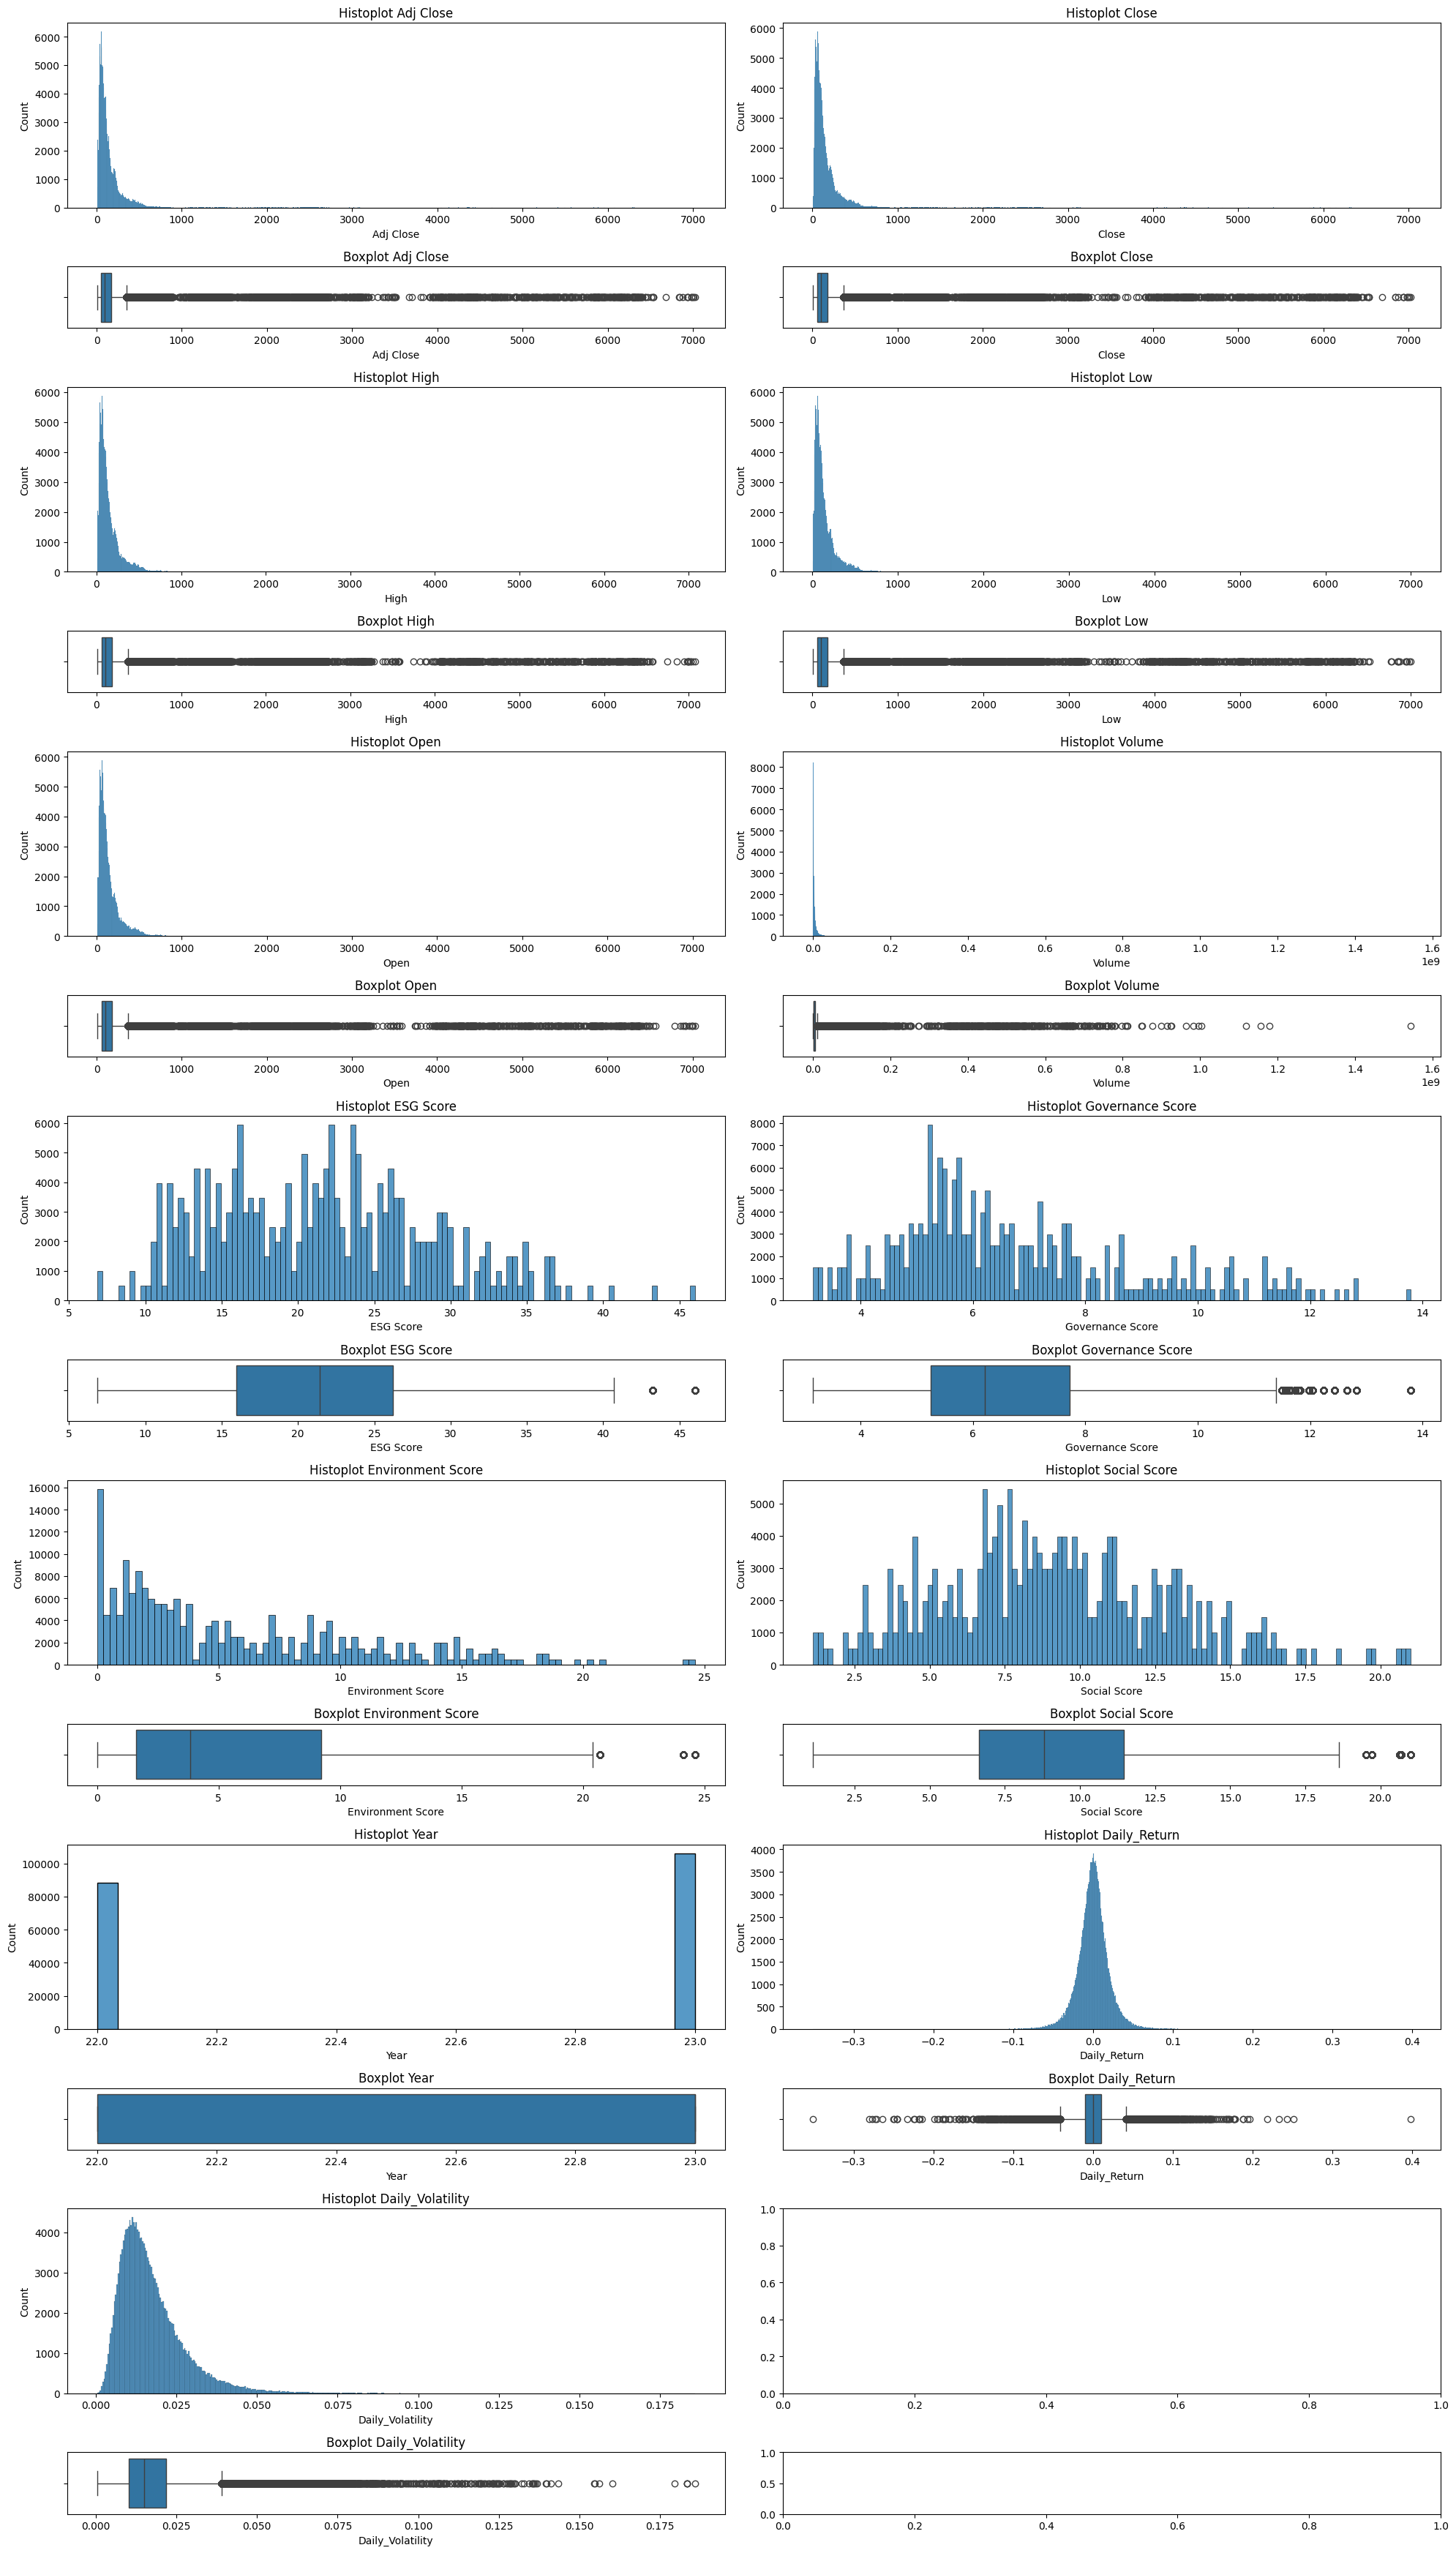

In [17]:
import matplotlib.pyplot as plt 
import seaborn as sns

numerical_variables = dataset_final.select_dtypes(include='number').columns
num_vars = len(numerical_variables)

# Number of rows: 2 per variable(histoplot + boxplot), 2 columns per row
ncols = 2
nrows = num_vars // ncols + (num_vars % ncols)
total_rows = nrows * 2  # double per variable.

fig, axes = plt.subplots(
    nrows=total_rows,
    ncols=ncols,
    figsize=(20, total_rows * 2.5),
    gridspec_kw={"height_ratios": [6, 2] * nrows}
)

axes = axes.reshape(total_rows, ncols)

# Automatic plot
for i, var in enumerate(numerical_variables):
    row = (i // ncols) * 2
    col = i % ncols

    # Histoplot
    sns.histplot(data=dataset_final, x=var, ax=axes[row, col])
    axes[row, col].set_title(f"Histoplot {var}")

    # Boxplot
    sns.boxplot(data=dataset_final, x=var, ax=axes[row + 1, col])
    axes[row + 1, col].set_title(f"Boxplot {var}")


plt.tight_layout()
plt.show()


In [18]:
# CATEGÓRICAS

categorical_variables = dataset_final.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical Variables:", categorical_variables)

Categorical Variables: ['Ticker', 'ESG Score Date', 'ESG Status', 'CEO Gender']


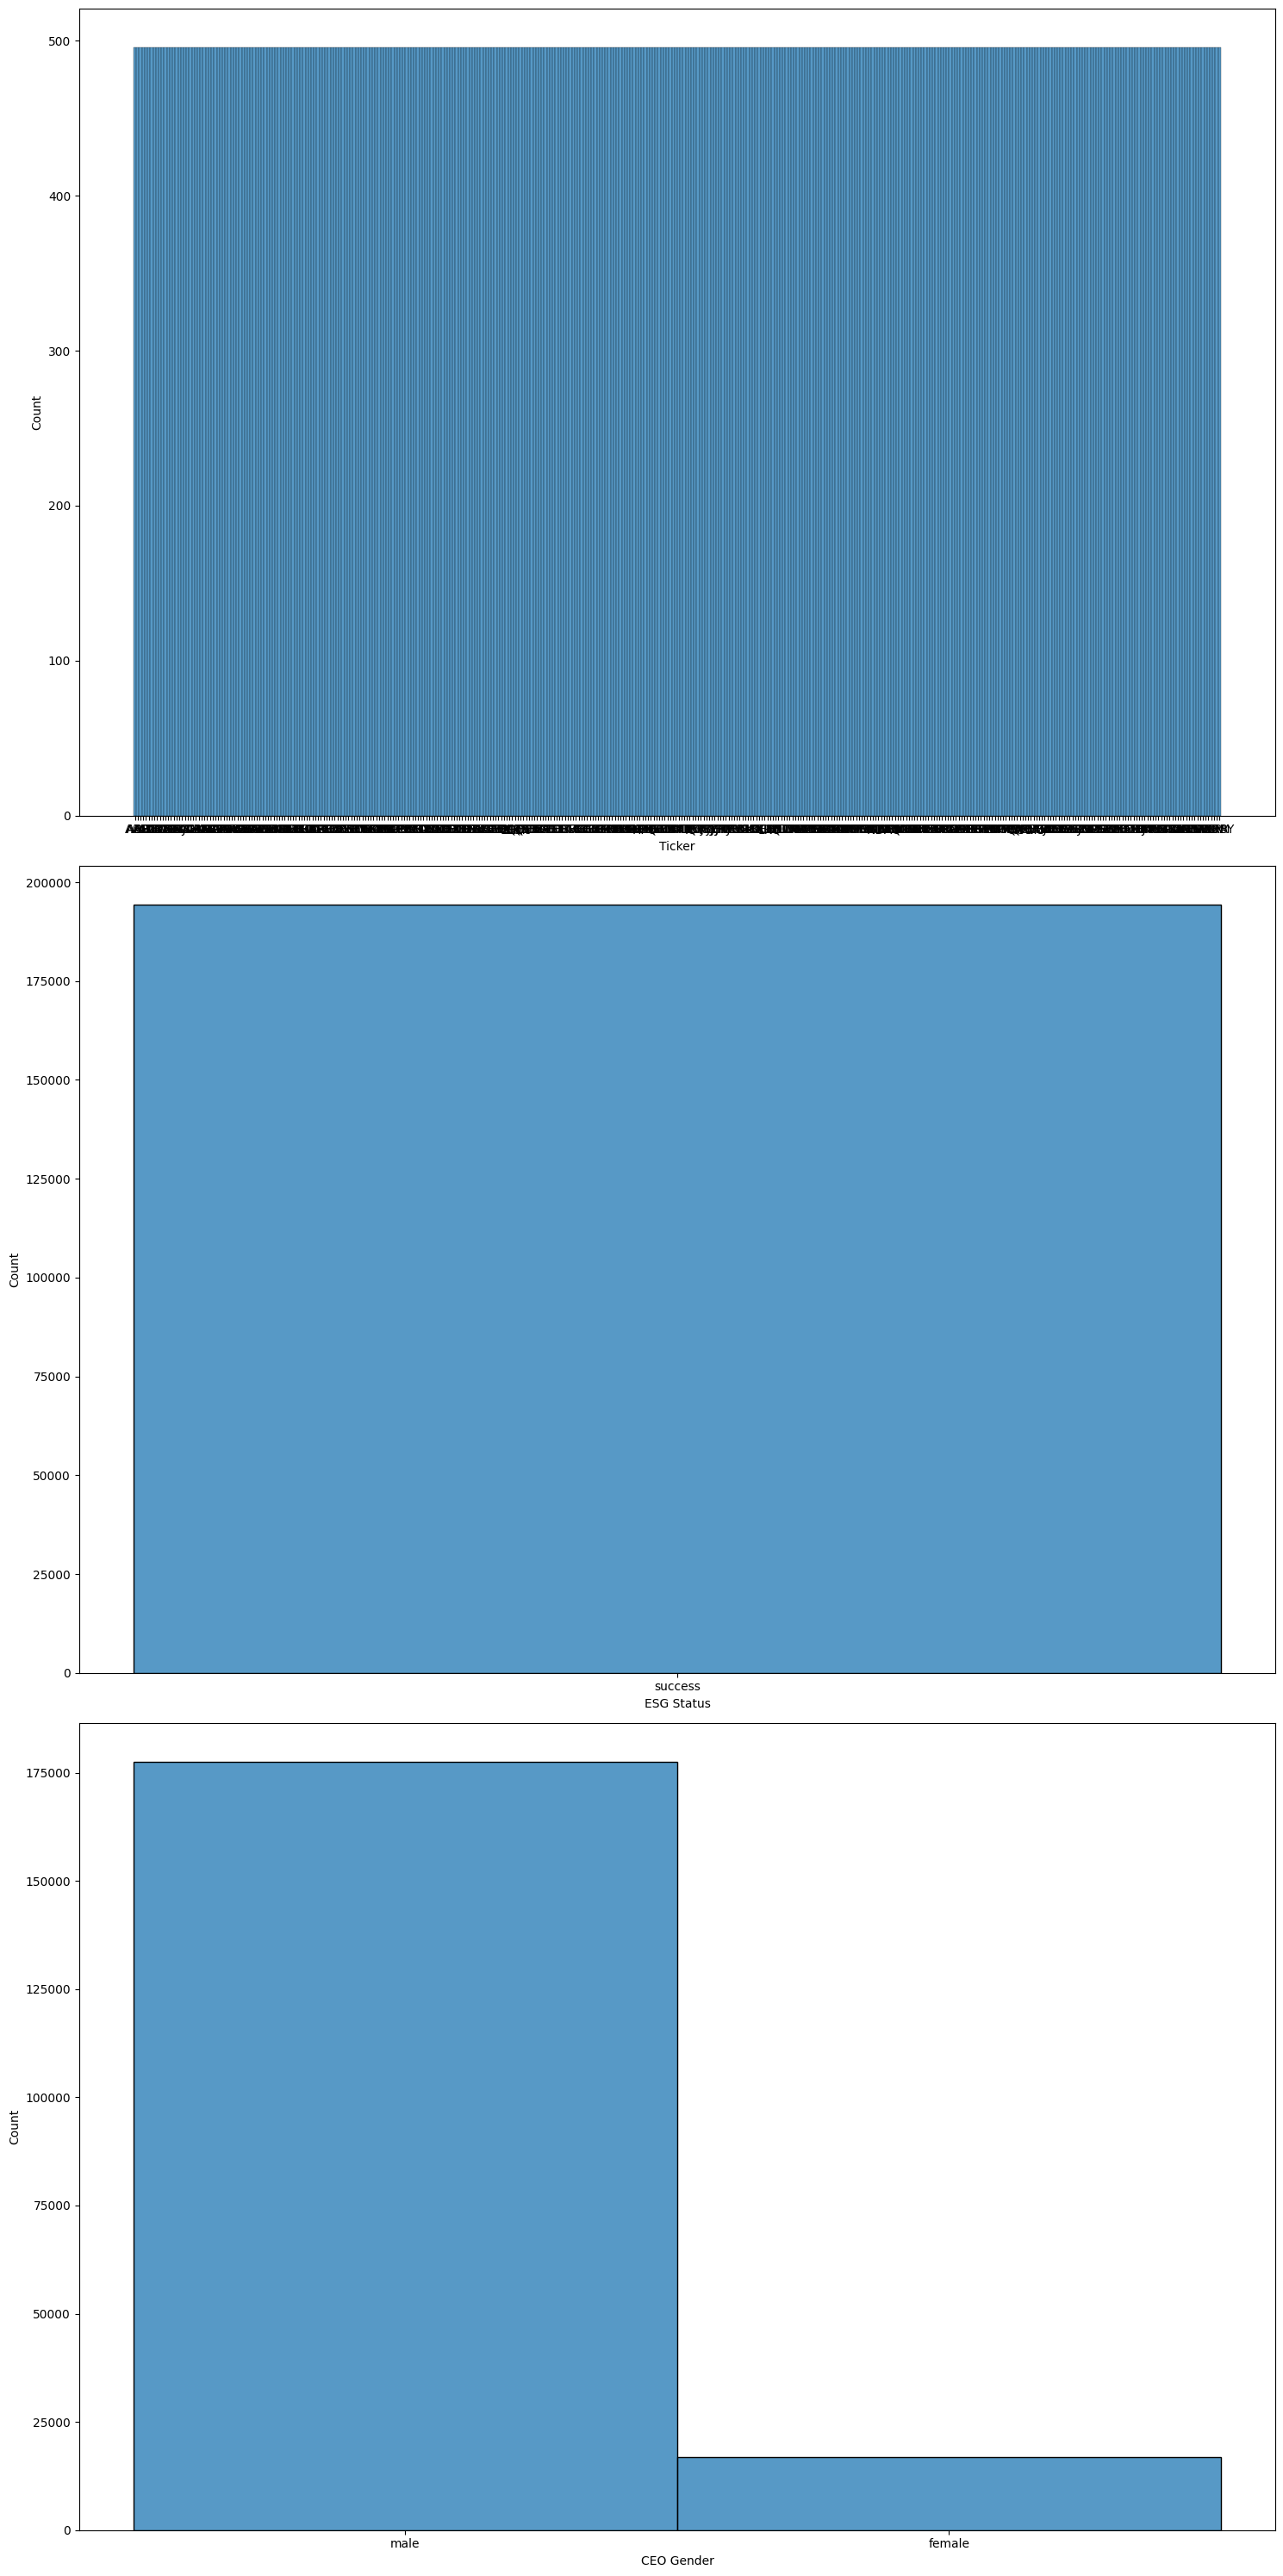

In [19]:

fig, axis = plt.subplots(3, figsize=(15, 30))

# Create a multiple histogram
sns.histplot(ax = axis[0], data = dataset_final, x = "Ticker") 
sns.histplot(ax = axis[1], data = dataset_final, x = "ESG Status")
sns.histplot(ax = axis[2], data = dataset_final, x = "CEO Gender")

plt.tight_layout()
plt.show()

In [20]:
#MULTIVARIANTE: numérico-numérico

numerical_variables

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'ESG Score',
       'Governance Score', 'Environment Score', 'Social Score', 'Year',
       'Daily_Return', 'Daily_Volatility'],
      dtype='object')

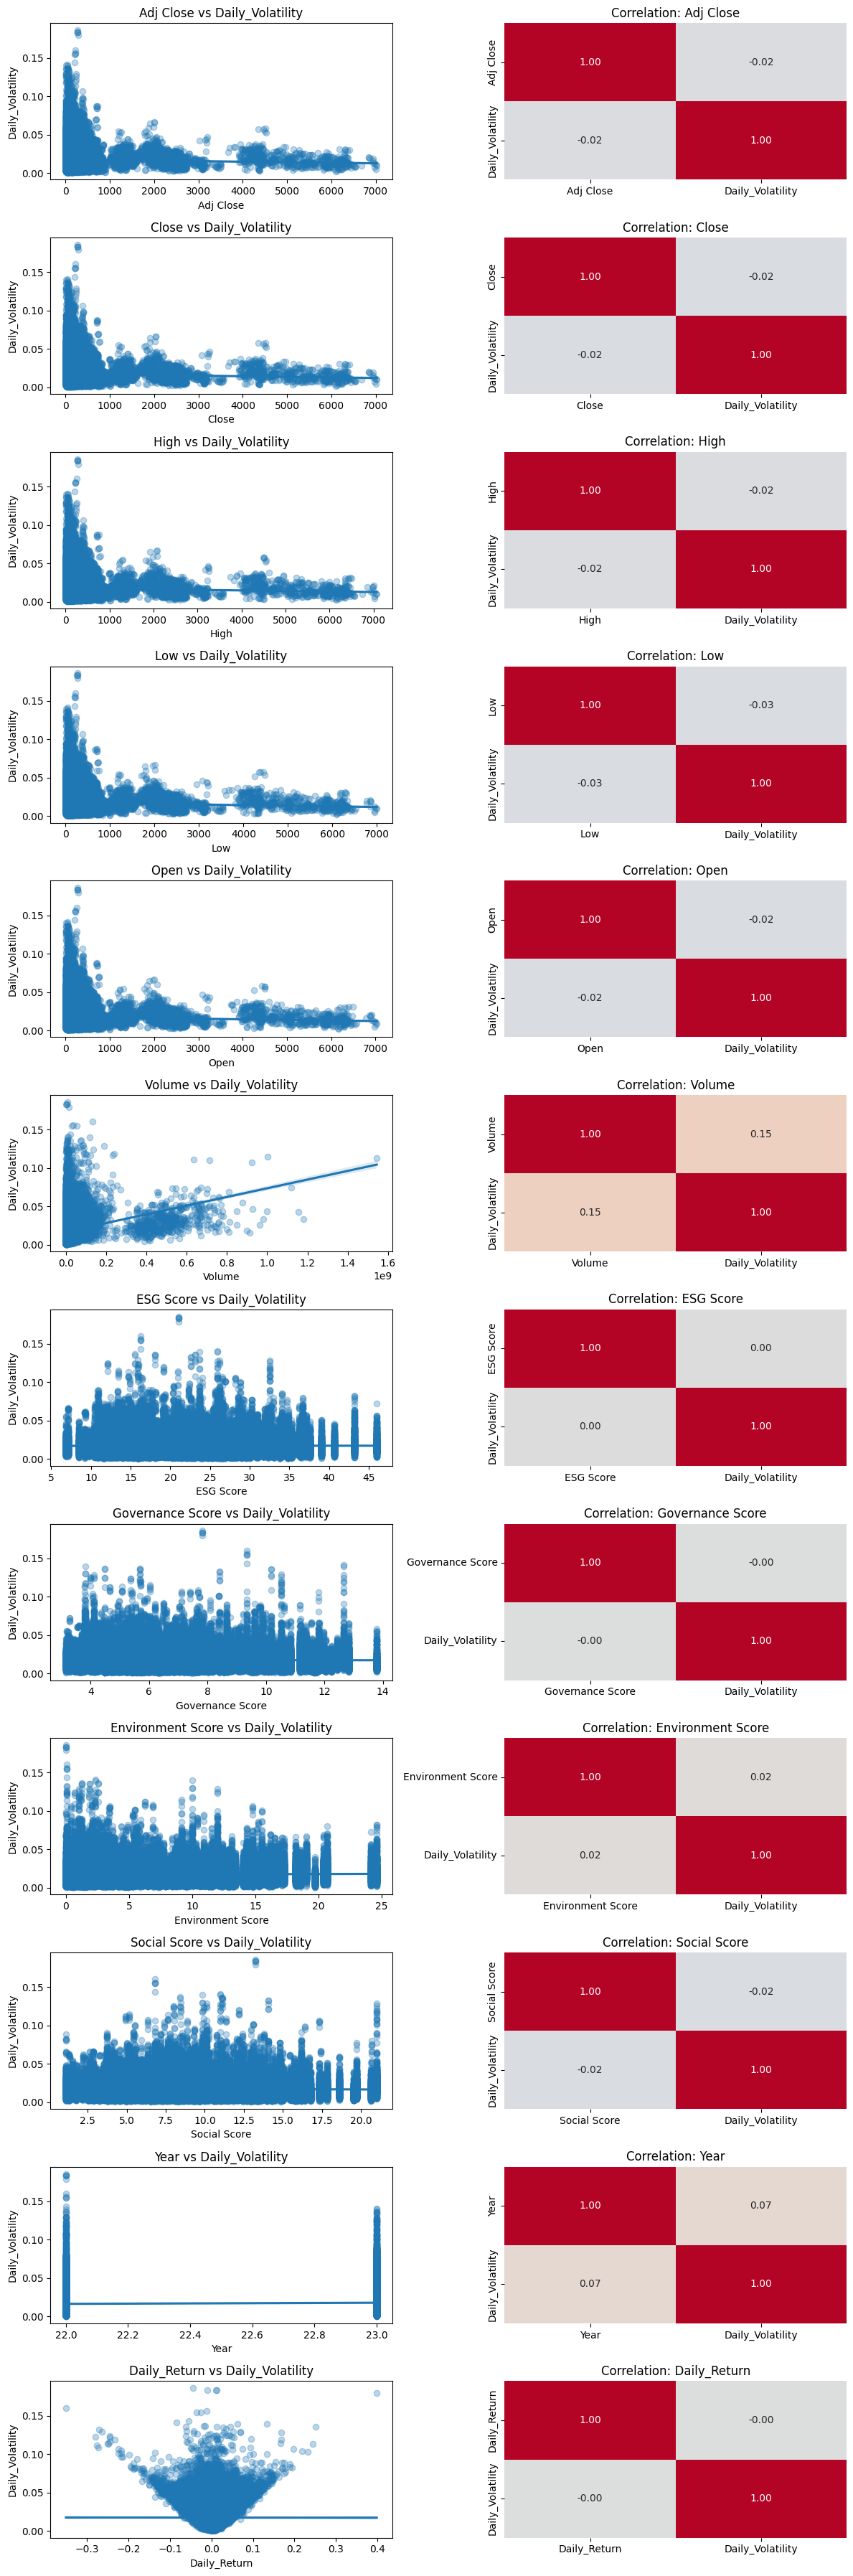

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Variables que quieres comparar con Daily_Volatility
variables = [
    "Adj Close", "Close", "High", "Low", "Open", "Volume",
    "ESG Score", "Governance Score", "Environment Score",
    "Social Score", "Year", "Daily_Return"
]

n_vars = len(variables)
ncols = 2   # un regplot y un heatmap por fila
nrows = n_vars  # una fila por variable

fig, axes = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(12, nrows * 3)
)

# Si solo hay 1 fila, convertir axes a 2D para que no dé error
if nrows == 1:
    axes = [axes]

for i, var in enumerate(variables):
    # Regplot a la izquierda
    sns.regplot(
        ax=axes[i, 0], 
        data=dataset_final, 
        x=var, 
        y="Daily_Volatility", 
        scatter_kws={"alpha": 0.3}
    )
    axes[i, 0].set_title(f"{var} vs Daily_Volatility")

    # Heatmap a la derecha
    corr = dataset_final[[var, "Daily_Volatility"]].corr()
    sns.heatmap(
        corr, 
        annot=True, 
        fmt=".2f", 
        ax=axes[i, 1], 
        cbar=False, 
        cmap="coolwarm",
        vmin=-1, vmax=1
    )
    axes[i, 1].set_title(f"Correlation: {var}")

plt.tight_layout()
plt.show()


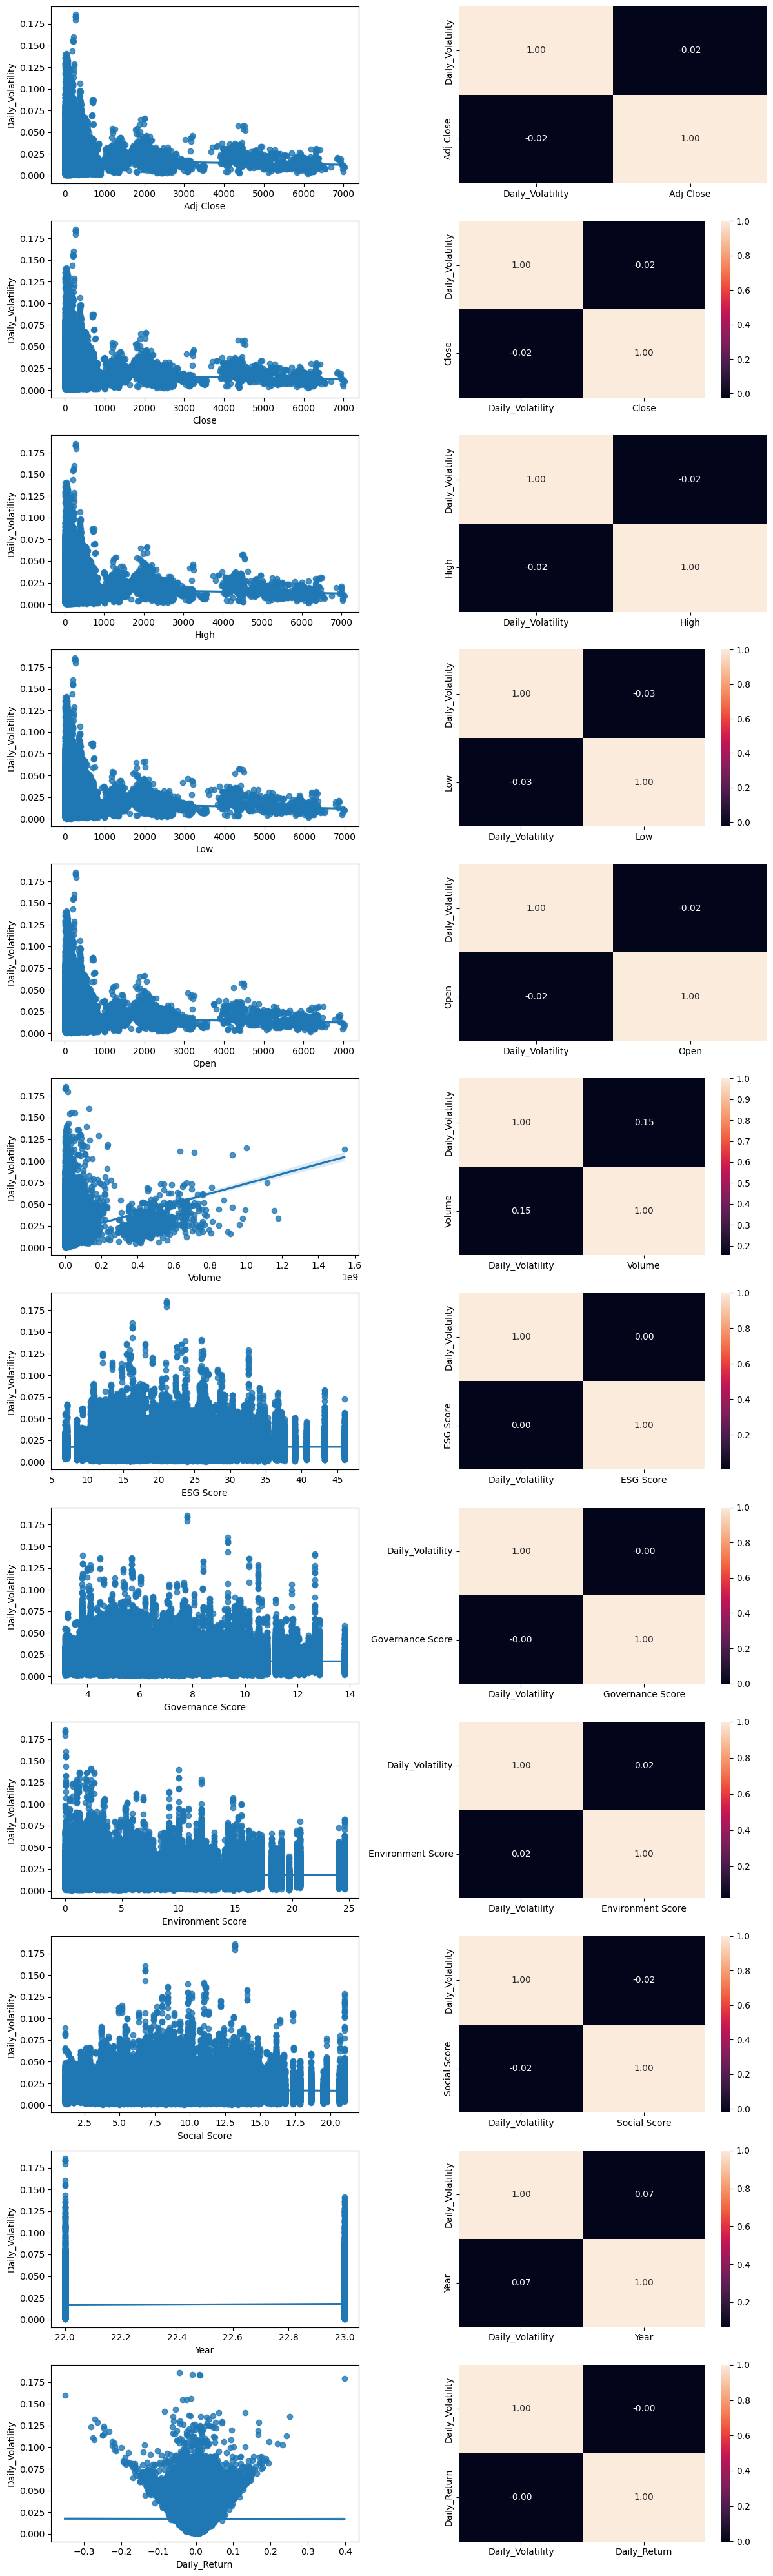

In [22]:
fig, axis = plt.subplots(12, 2, figsize=(12, 40))  # 12 variables → 12 filas x 2 columnas

sns.regplot(ax=axis[0, 0], data=dataset_final, x="Adj Close", y="Daily_Volatility")
sns.heatmap(dataset_final[["Daily_Volatility", "Adj Close"]].corr(), annot=True, fmt=".2f", ax=axis[0, 1], cbar=False)

sns.regplot(ax=axis[1, 0], data=dataset_final, x="Close", y="Daily_Volatility")
sns.heatmap(dataset_final[["Daily_Volatility", "Close"]].corr(), annot=True, fmt=".2f", ax=axis[1, 1])

sns.regplot(ax=axis[2, 0], data=dataset_final, x="High", y="Daily_Volatility")
sns.heatmap(dataset_final[["Daily_Volatility", "High"]].corr(), annot=True, fmt=".2f", ax=axis[2, 1], cbar=False)

sns.regplot(ax=axis[3, 0], data=dataset_final, x="Low", y="Daily_Volatility")
sns.heatmap(dataset_final[["Daily_Volatility", "Low"]].corr(), annot=True, fmt=".2f", ax=axis[3, 1])

sns.regplot(ax=axis[4, 0], data=dataset_final, x="Open", y="Daily_Volatility")
sns.heatmap(dataset_final[["Daily_Volatility", "Open"]].corr(), annot=True, fmt=".2f", ax=axis[4, 1], cbar=False)

sns.regplot(ax=axis[5, 0], data=dataset_final, x="Volume", y="Daily_Volatility")
sns.heatmap(dataset_final[["Daily_Volatility", "Volume"]].corr(), annot=True, fmt=".2f", ax=axis[5, 1])

sns.regplot(ax=axis[6, 0], data=dataset_final, x="ESG Score", y="Daily_Volatility")
sns.heatmap(dataset_final[["Daily_Volatility", "ESG Score"]].corr(), annot=True, fmt=".2f", ax=axis[6, 1])

sns.regplot(ax=axis[7, 0], data=dataset_final, x="Governance Score", y="Daily_Volatility")
sns.heatmap(dataset_final[["Daily_Volatility", "Governance Score"]].corr(), annot=True, fmt=".2f", ax=axis[7, 1])

sns.regplot(ax=axis[8, 0], data=dataset_final, x="Environment Score", y="Daily_Volatility")
sns.heatmap(dataset_final[["Daily_Volatility", "Environment Score"]].corr(), annot=True, fmt=".2f", ax=axis[8, 1])

sns.regplot(ax=axis[9, 0], data=dataset_final, x="Social Score", y="Daily_Volatility")
sns.heatmap(dataset_final[["Daily_Volatility", "Social Score"]].corr(), annot=True, fmt=".2f", ax=axis[9, 1])

sns.regplot(ax=axis[10, 0], data=dataset_final, x="Year", y="Daily_Volatility")
sns.heatmap(dataset_final[["Daily_Volatility", "Year"]].corr(), annot=True, fmt=".2f", ax=axis[10, 1])

sns.regplot(ax=axis[11, 0], data=dataset_final, x="Daily_Return", y="Daily_Volatility")
sns.heatmap(dataset_final[["Daily_Volatility", "Daily_Return"]].corr(), annot=True, fmt=".2f", ax=axis[11, 1])

plt.tight_layout()
plt.show()


MULTIVARIANTE CATEGÓRICO-CATEGÓRICO

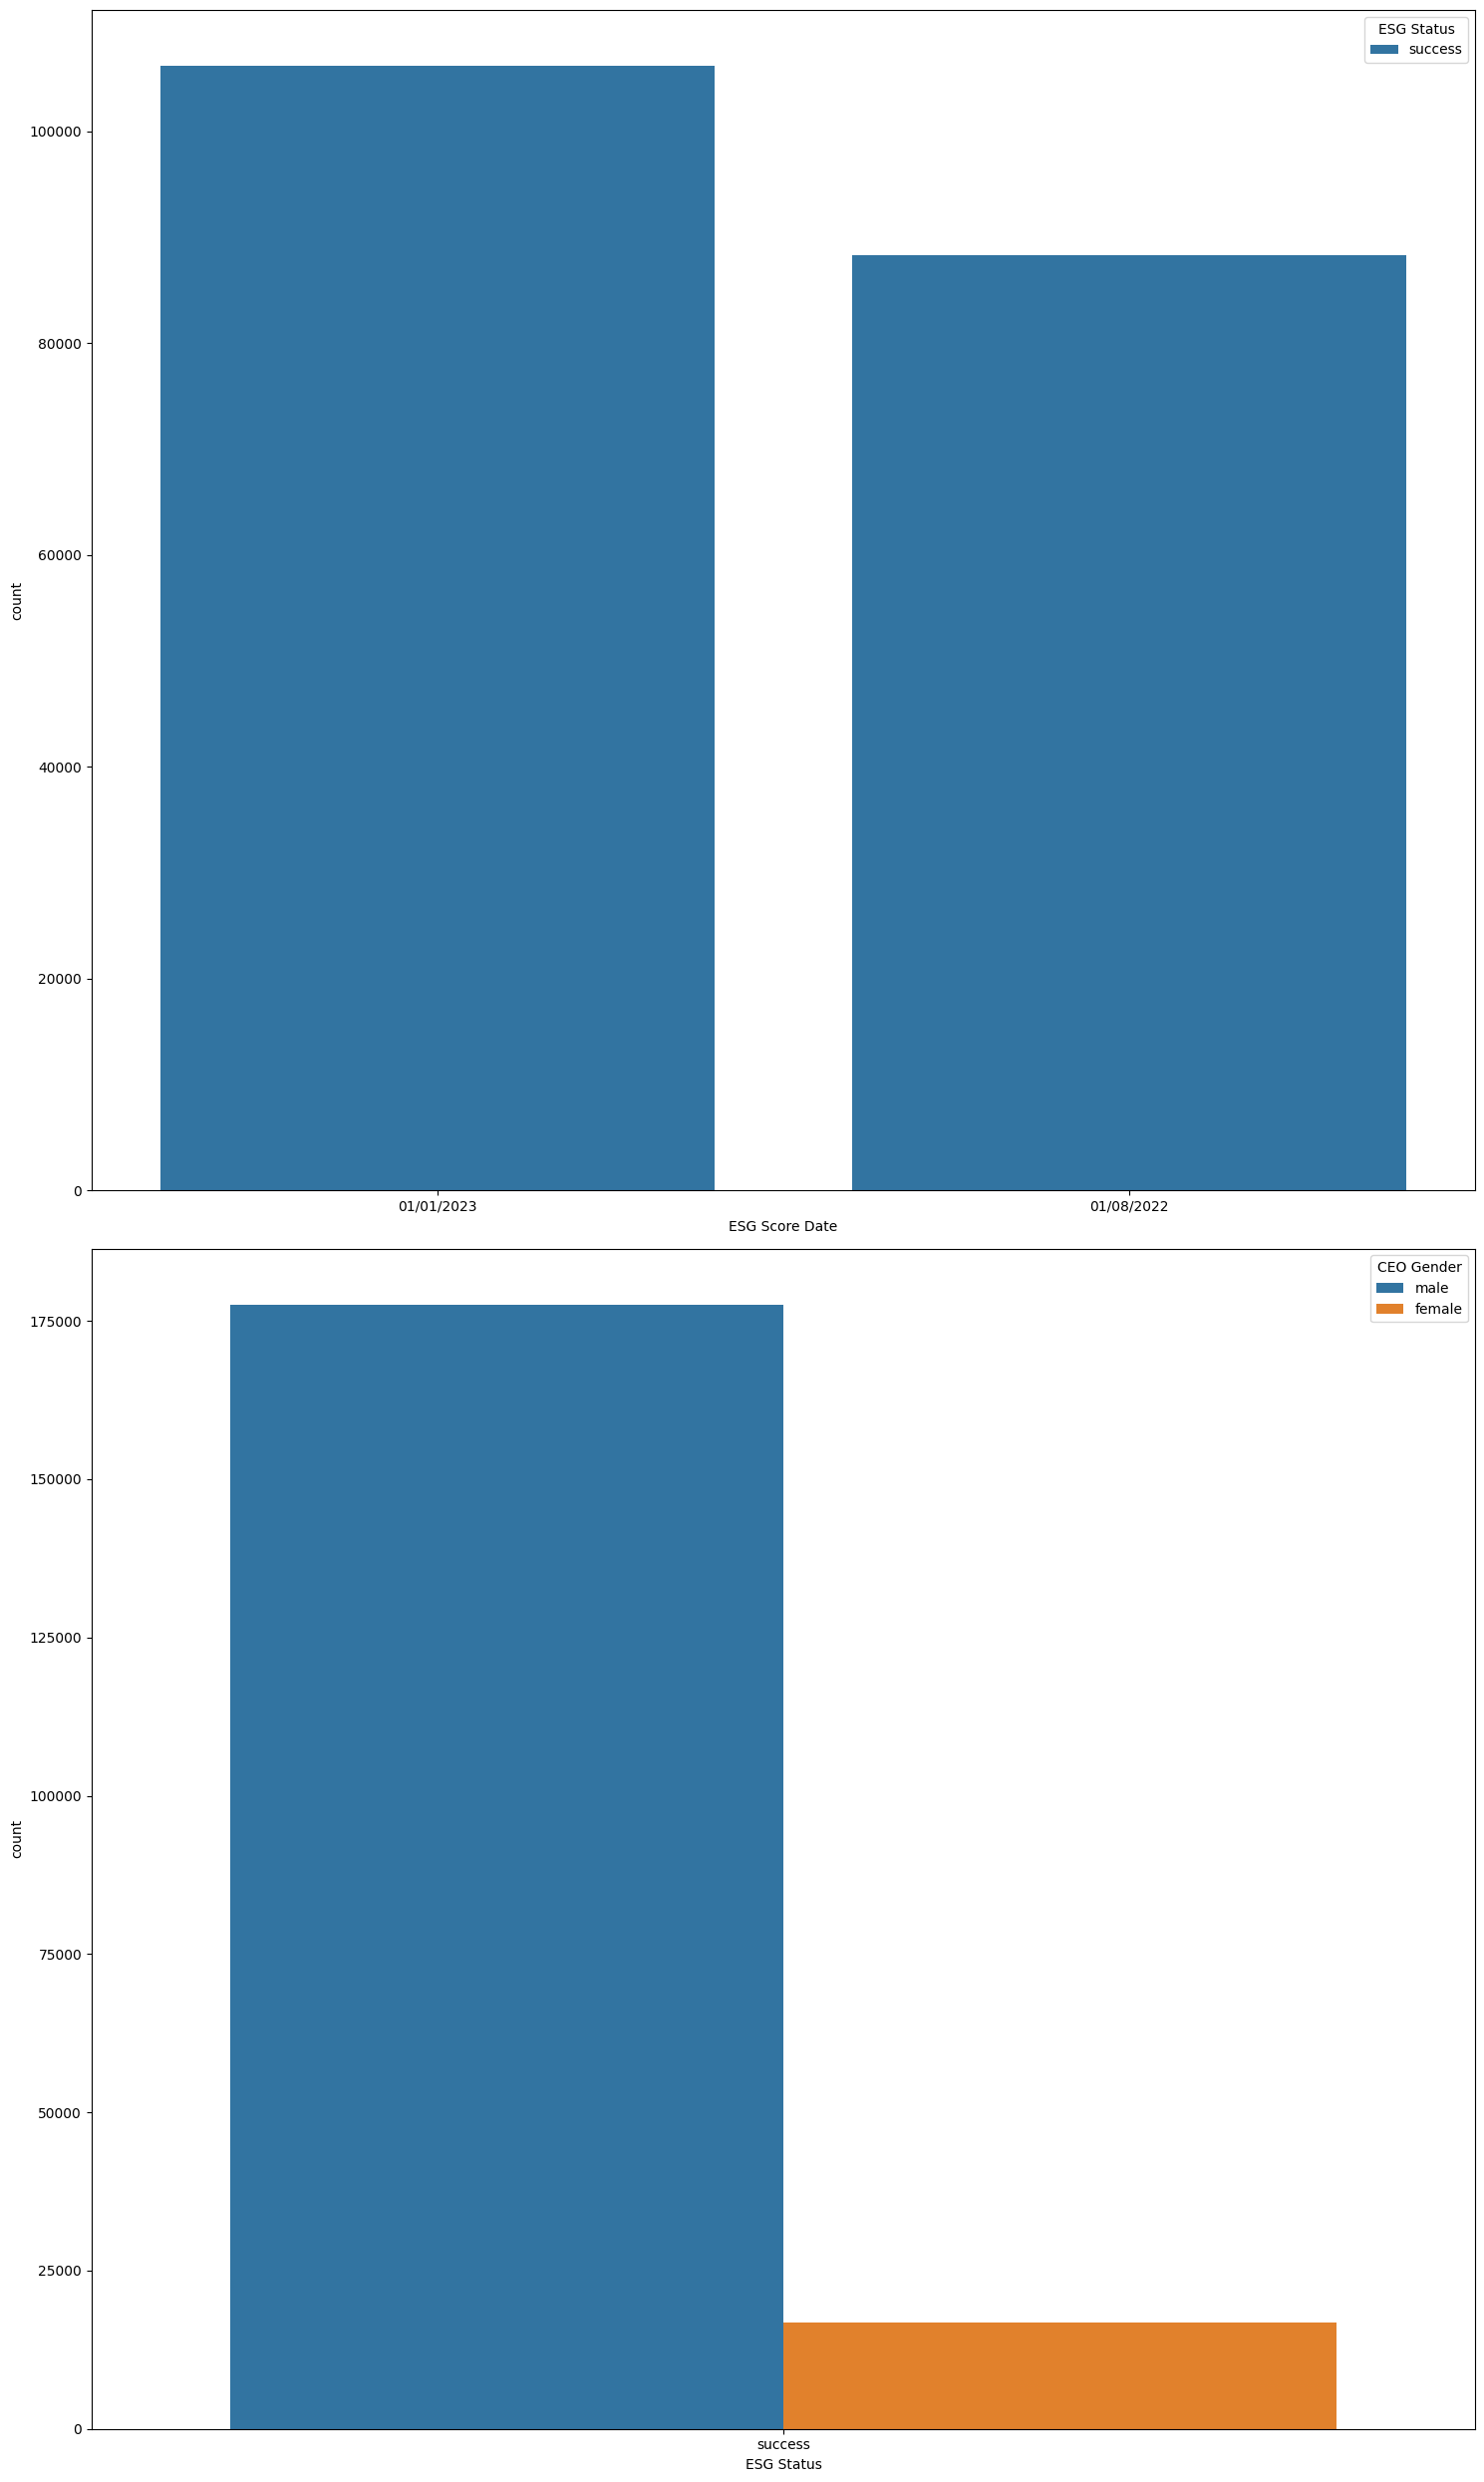

In [23]:
fig, axis = plt.subplots(2, 1, figsize=(15, 25))  

sns.countplot(data=dataset_final, x="ESG Score Date", hue="ESG Status", ax=axis[0])
sns.countplot(data=dataset_final, x="ESG Status", hue="CEO Gender", ax=axis[1])

plt.tight_layout()
plt.show()


## A revisar

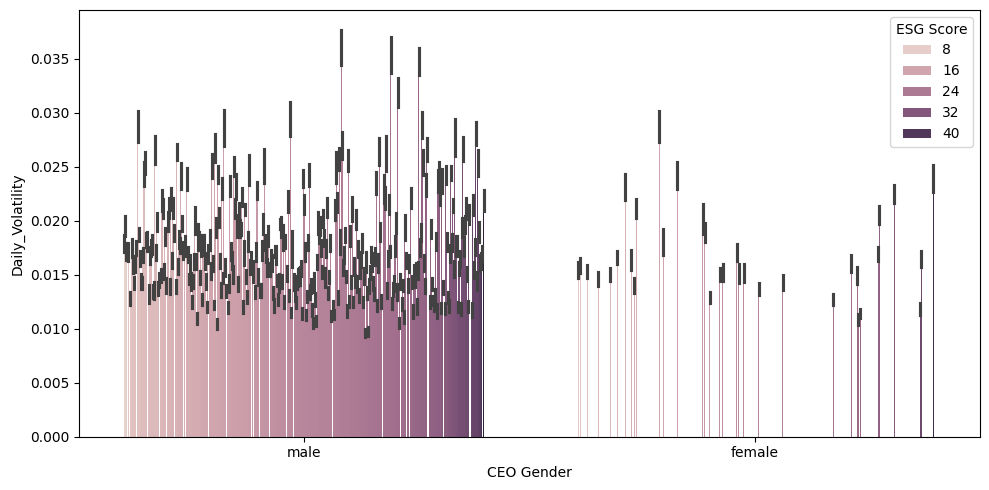

In [24]:
fig, axis = plt.subplots(figsize = (10, 5), ncols = 1)

sns.barplot(data = dataset_final, x = "CEO Gender", y = "Daily_Volatility", hue = "ESG Score")

plt.tight_layout()

plt.show()

# ANÁLISIS DE CORRELACIONES

In [25]:
import json 

categorical_f_rules = {}

for col in categorical_variables:
    encoded_col = f"{col}_n"
    dataset_final[encoded_col], uniques = pd.factorize(dataset_final[col])
    dicc = dict(zip(uniques, range(len(uniques))))
    categorical_f_rules[col] = dicc

with open("categorical_rules.json", "w") as f:
    json.dump(categorical_f_rules, f)

with open("categorical_rules.json", "r") as f:
    loaded_mappings = json.load(f)

dataset_final.head()

Date Ticker   Adj Close       Close        High         Low  \
5 2022-01-10      A  141.584717  145.160004  145.309998  140.860001   
6 2022-01-11      A  143.028275  146.639999  146.940002  143.809998   
7 2022-01-12      A  145.827576  149.509995  150.389999  147.550003   
8 2022-01-13      A  141.594452  145.169998  149.539993  144.850006   
9 2022-01-14      A  141.116562  144.679993  145.149994  142.360001   

         Open     Volume  ESG Score  Governance Score  ...  ESG Score Date  \
5  143.289993  2548100.0      15.24              6.26  ...      01/01/2023   
6  145.000000  2194200.0      15.24              6.26  ...      01/01/2023   
7  147.800003  2250800.0      15.24              6.26  ...      01/01/2023   
8  149.460007  1741800.0      15.24              6.26  ...      01/01/2023   
9  144.039993  2225400.0      15.24              6.26  ...      01/01/2023   

   ESG Status CEO Gender Year Daily_Return  Daily_Volatility  Ticker_n  \
5     success       male   23     0.000069          0.016297         0   
6     success       male   23     0.010196          0.015318         0   
7     success       male   23     0.019572          0.017313         0   
8     success       male   23    -0.029028          0.021824         0   
9     success       male   23    -0.003375          0.018301         0   

   ESG Score Date_n  ESG Status_n  CEO Gender_n  
5                 0             0             0  
6                 0             0             0  
7                 0             0             0  
8                 0             0             0  
9                 0             0             0  

[5 rows x 22 columns]

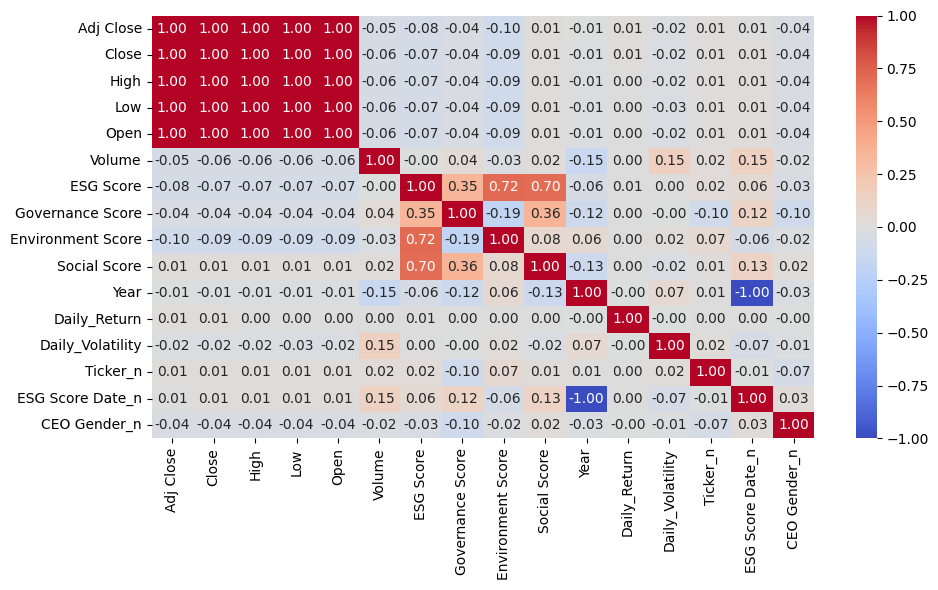

In [26]:
fig, axis = plt.subplots(figsize=(10, 6))

sns.heatmap(
    dataset_final[[
        "Adj Close", "Close", "High", "Low", "Open", "Volume",
        "ESG Score", "Governance Score", "Environment Score", "Social Score",
        "Year", "Daily_Return", "Daily_Volatility",
        "Ticker_n", "ESG Score Date_n",
        "CEO Gender_n"
    ]].corr(),
    annot=True,
    fmt=".2f",
    cmap="coolwarm"
)

plt.tight_layout()
plt.show()


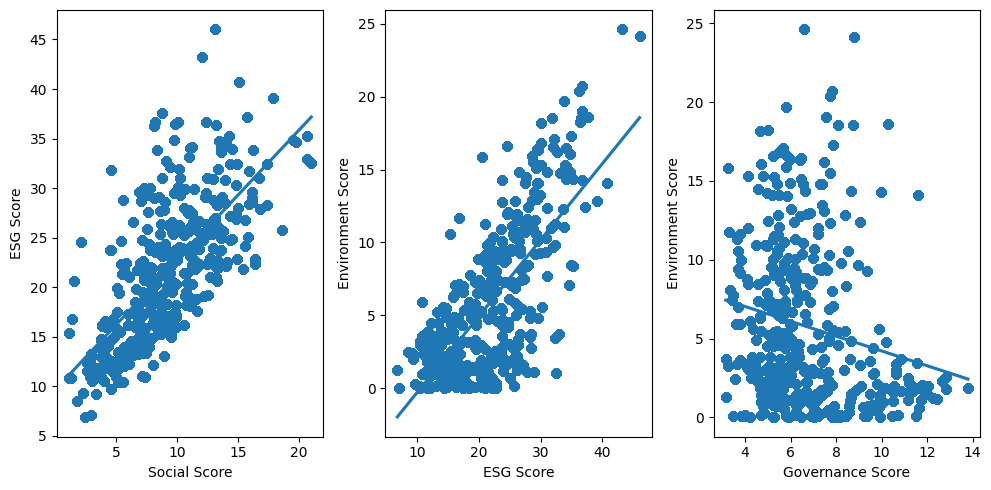

In [27]:
fig, axis = plt.subplots(figsize = (10, 5), ncols = 3)
sns.regplot(ax = axis[0], data = dataset_final, x = "Social Score", y = "ESG Score")
sns.regplot(ax = axis[1], data = dataset_final, x = "ESG Score", y = "Environment Score")
sns.regplot(ax = axis[2], data = dataset_final, x = "Governance Score", y = "Environment Score")

plt.tight_layout()
plt.show()

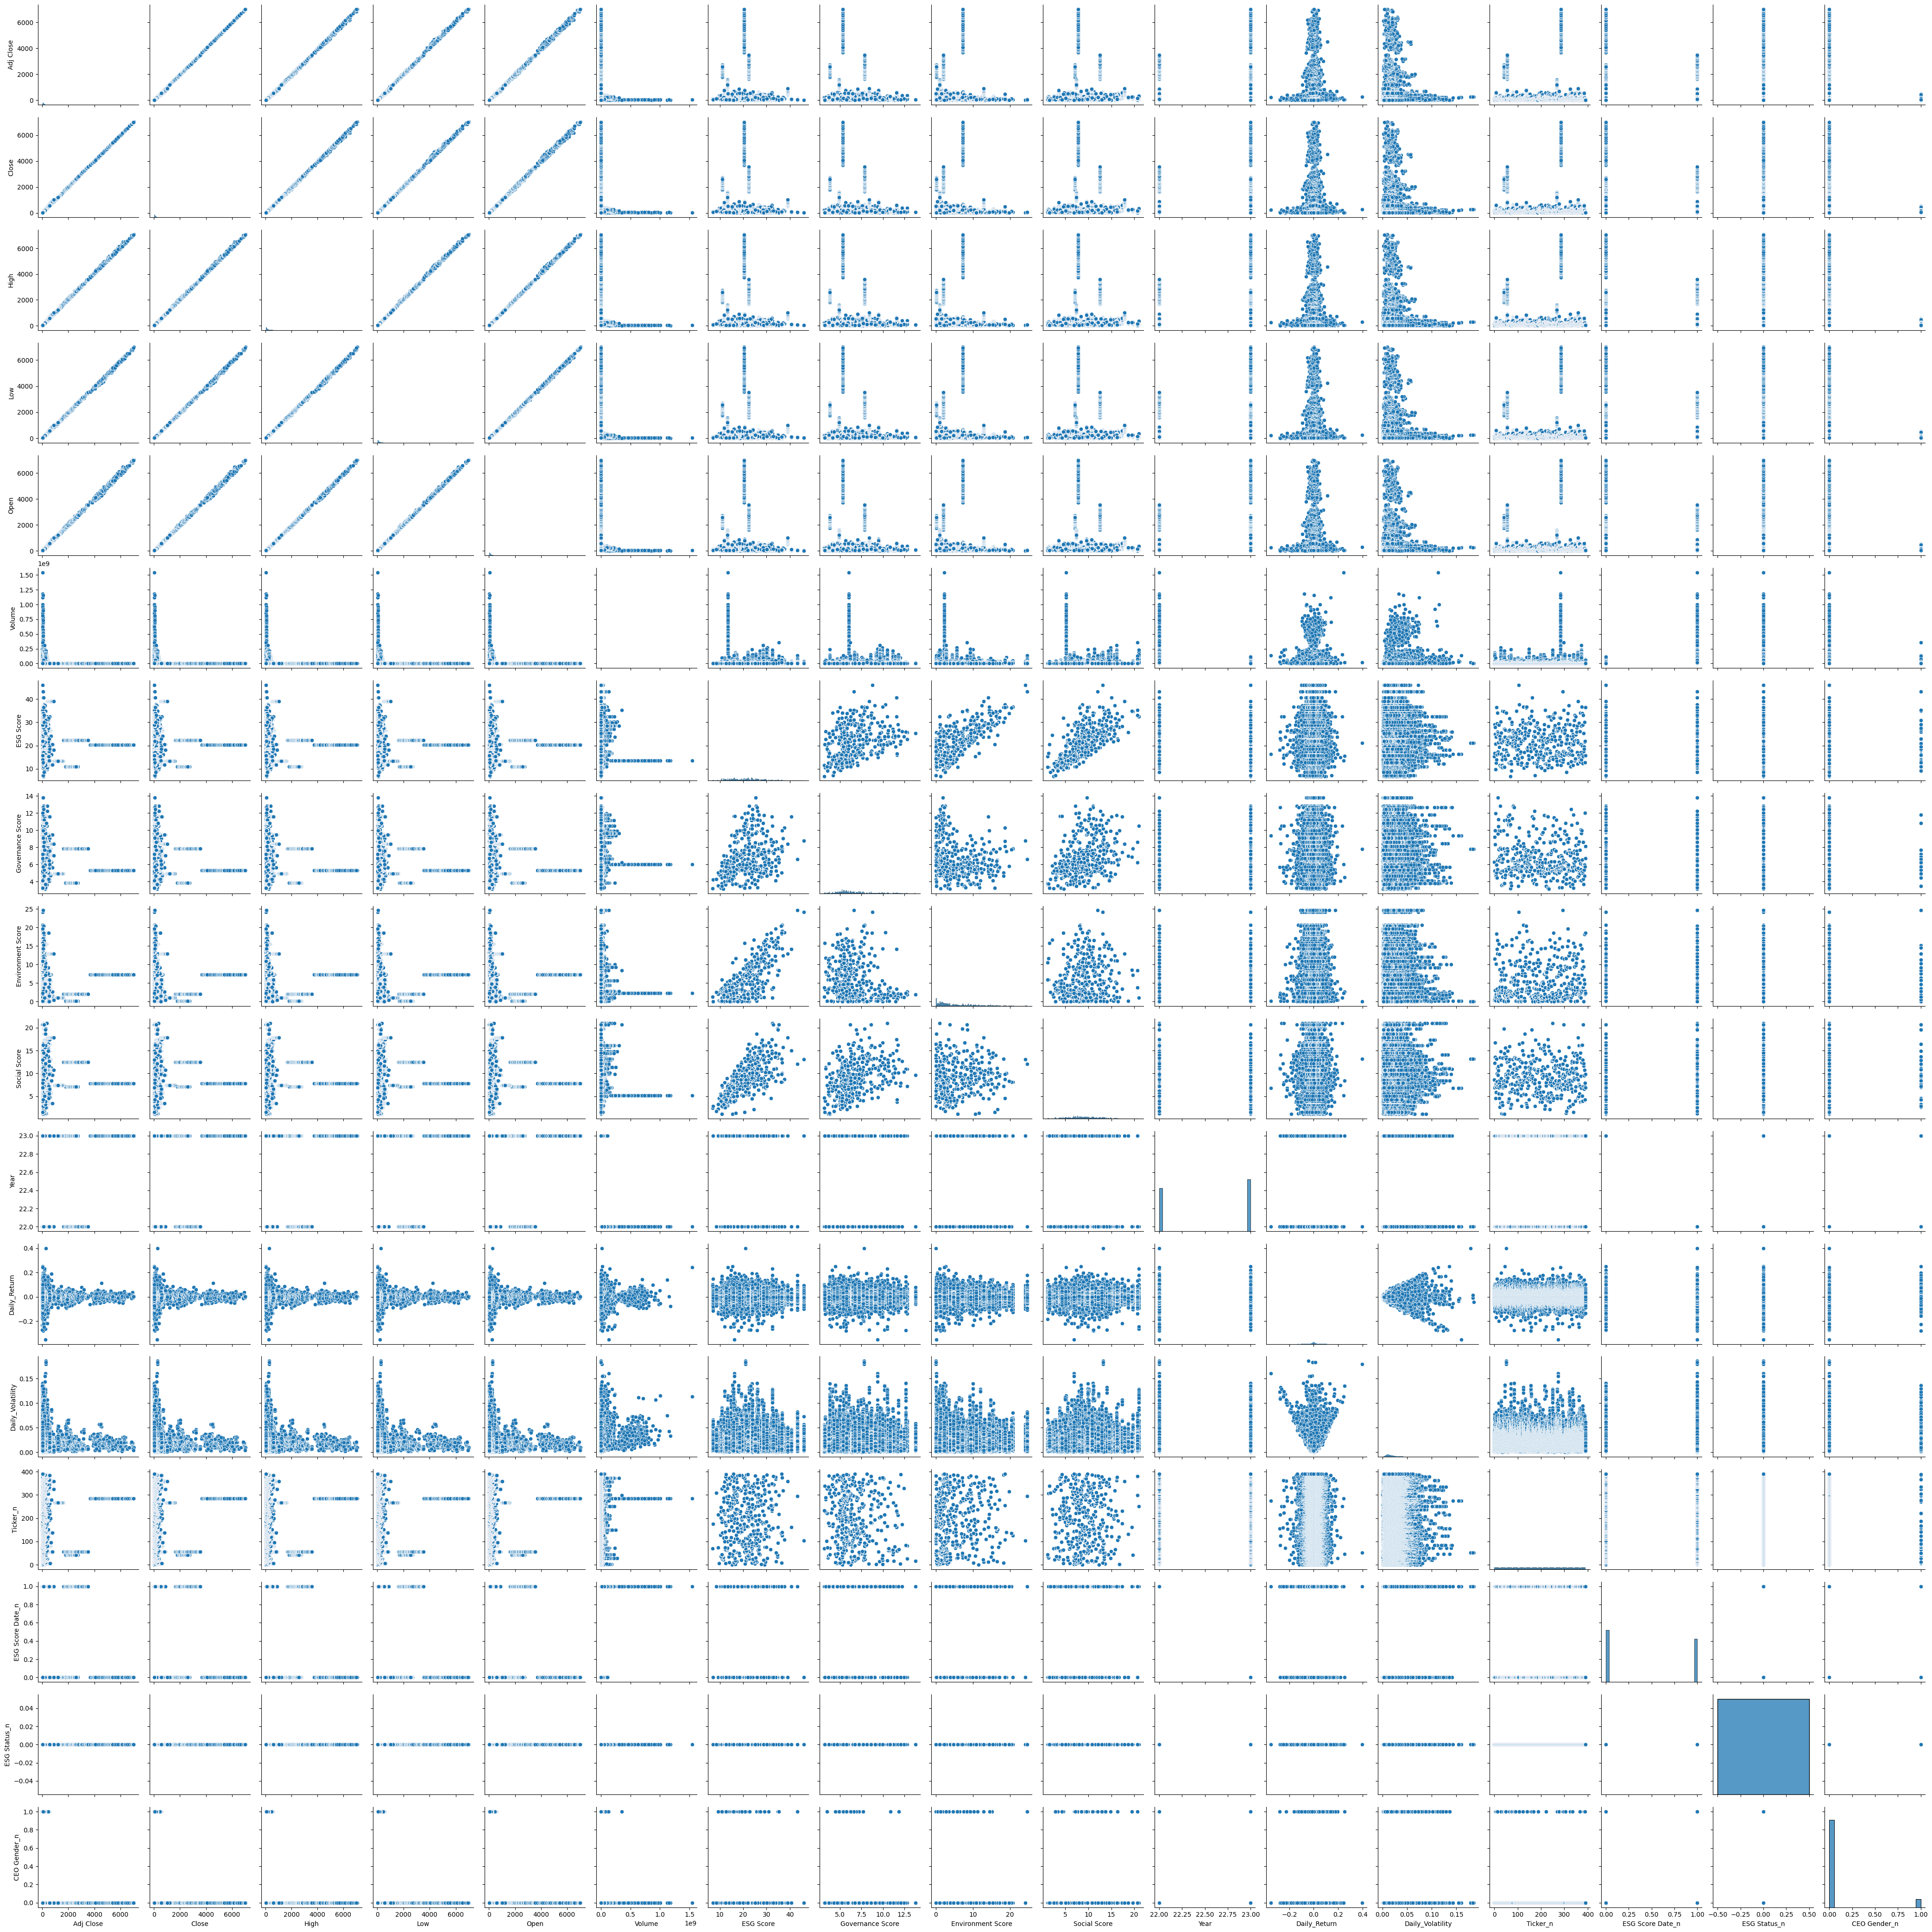

In [28]:
sns.pairplot(data = dataset_final)

In [29]:
dataset_final.describe()

Date      Adj Close          Close  \
count                         194432  194432.000000  194432.000000   
mean   2023-01-04 06:52:15.483871232     160.952069     167.388926   
min              2022-01-10 00:00:00       6.380000       6.380000   
25%              2022-07-10 06:00:00      54.951445      58.689999   
50%              2023-01-04 12:00:00      95.675552     101.309998   
75%              2023-07-05 06:00:00     172.638763     181.679993   
max              2023-12-29 00:00:00    7024.819824    7024.819824   
std                              NaN     331.434565     332.953698   

                High            Low           Open        Volume  \
count  194432.000000  194432.000000  194432.000000  1.944320e+05   
mean      169.368992     165.331806     167.345709  6.552061e+06   
min         6.740000       6.110000       6.420000  6.400000e+03   
25%        59.419998      57.950001      58.709999  1.071500e+06   
50%       102.559998      99.980003     101.260002  2.154600e+06   
75%       183.779999     179.509995     181.639999  4.925325e+06   
max      7075.000000    6997.910156    7028.500000  1.543911e+09   
std       336.914249     328.891816     332.770562  2.884069e+07   

           ESG Score  Governance Score  Environment Score   Social Score  \
count  194432.000000     194432.000000      194432.000000  194432.000000   
mean       21.568444          6.717755           5.755510       9.095230   
min         6.840000          3.150000           0.000000       1.110000   
25%        15.940000          5.250000           1.595000       6.647500   
50%        21.435000          6.205000           3.820000       8.810000   
75%        26.242500          7.722500           9.215000      11.462500   
max        46.020000         13.790000          24.610000      21.010000   
std         7.112719          2.142073           5.206709       3.787409   

                Year   Daily_Return  Daily_Volatility       Ticker_n  \
count  194432.000000  194432.000000     194432.000000  194432.000000   
mean       22.545918       0.000226          0.017352     195.500000   
min        22.000000      -0.351166          0.000479       0.000000   
25%        22.000000      -0.010178          0.010248      97.750000   
50%        23.000000       0.000345          0.014977     195.500000   
75%        23.000000       0.010650          0.021751     293.250000   
max        23.000000       0.398503          0.185806     391.000000   
std         0.497888       0.020220          0.010542     113.160576   

       ESG Score Date_n  ESG Status_n   CEO Gender_n  
count     194432.000000      194432.0  194432.000000  
mean           0.454082           0.0       0.086735  
min            0.000000           0.0       0.000000  
25%            0.000000           0.0       0.000000  
50%            0.000000           0.0       0.000000  
75%            1.000000           0.0       0.000000  
max            1.000000           0.0       1.000000  
std            0.497888           0.0       0.281447

OUTLIERS

In [30]:
dataset_final.describe()

Date      Adj Close          Close  \
count                         194432  194432.000000  194432.000000   
mean   2023-01-04 06:52:15.483871232     160.952069     167.388926   
min              2022-01-10 00:00:00       6.380000       6.380000   
25%              2022-07-10 06:00:00      54.951445      58.689999   
50%              2023-01-04 12:00:00      95.675552     101.309998   
75%              2023-07-05 06:00:00     172.638763     181.679993   
max              2023-12-29 00:00:00    7024.819824    7024.819824   
std                              NaN     331.434565     332.953698   

                High            Low           Open        Volume  \
count  194432.000000  194432.000000  194432.000000  1.944320e+05   
mean      169.368992     165.331806     167.345709  6.552061e+06   
min         6.740000       6.110000       6.420000  6.400000e+03   
25%        59.419998      57.950001      58.709999  1.071500e+06   
50%       102.559998      99.980003     101.260002  2.154600e+06   
75%       183.779999     179.509995     181.639999  4.925325e+06   
max      7075.000000    6997.910156    7028.500000  1.543911e+09   
std       336.914249     328.891816     332.770562  2.884069e+07   

           ESG Score  Governance Score  Environment Score   Social Score  \
count  194432.000000     194432.000000      194432.000000  194432.000000   
mean       21.568444          6.717755           5.755510       9.095230   
min         6.840000          3.150000           0.000000       1.110000   
25%        15.940000          5.250000           1.595000       6.647500   
50%        21.435000          6.205000           3.820000       8.810000   
75%        26.242500          7.722500           9.215000      11.462500   
max        46.020000         13.790000          24.610000      21.010000   
std         7.112719          2.142073           5.206709       3.787409   

                Year   Daily_Return  Daily_Volatility       Ticker_n  \
count  194432.000000  194432.000000     194432.000000  194432.000000   
mean       22.545918       0.000226          0.017352     195.500000   
min        22.000000      -0.351166          0.000479       0.000000   
25%        22.000000      -0.010178          0.010248      97.750000   
50%        23.000000       0.000345          0.014977     195.500000   
75%        23.000000       0.010650          0.021751     293.250000   
max        23.000000       0.398503          0.185806     391.000000   
std         0.497888       0.020220          0.010542     113.160576   

       ESG Score Date_n  ESG Status_n   CEO Gender_n  
count     194432.000000      194432.0  194432.000000  
mean           0.454082           0.0       0.086735  
min            0.000000           0.0       0.000000  
25%            0.000000           0.0       0.000000  
50%            0.000000           0.0       0.000000  
75%            1.000000           0.0       0.000000  
max            1.000000           0.0       1.000000  
std            0.497888           0.0       0.281447

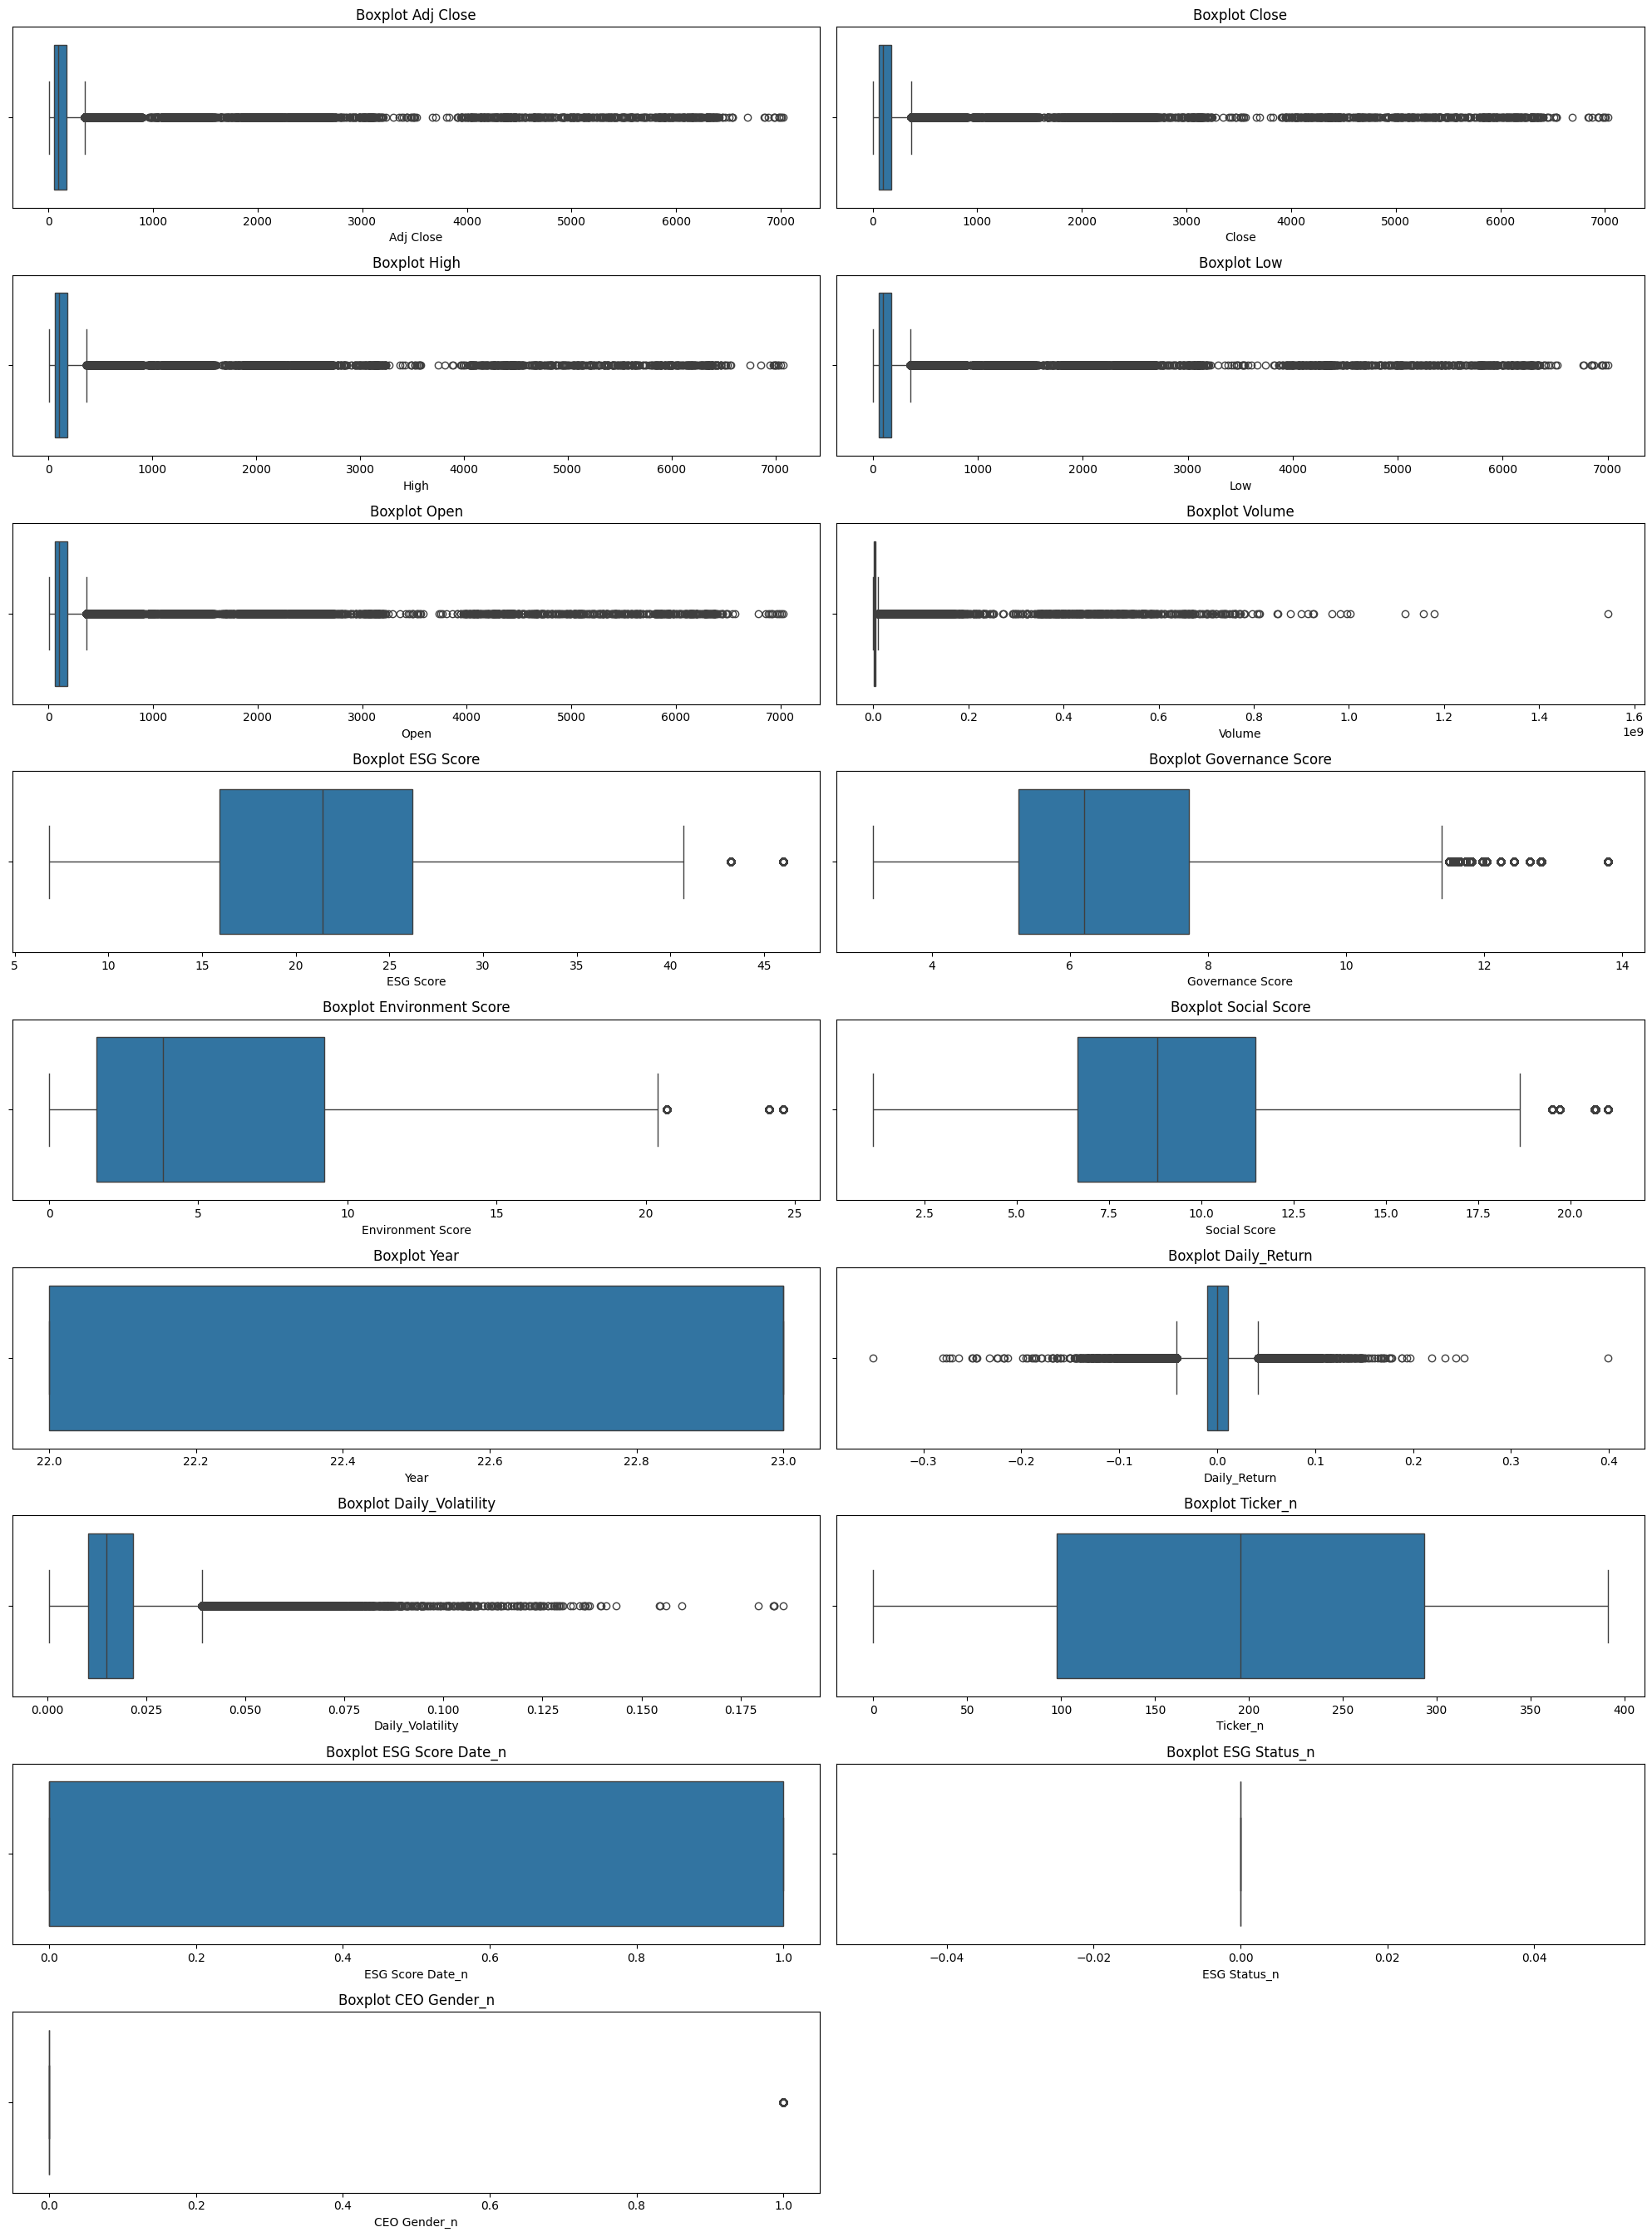

In [31]:
numerical_variables = dataset_final.select_dtypes(include='number').columns
num_vars = len(numerical_variables)# Definir grid
ncols = 2
nrows = num_vars // ncols + (num_vars % ncols)

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(20, nrows * 3)
)

axes = axes.flatten()# Solo boxplots
for i, var in enumerate(numerical_variables):
    sns.boxplot(data=dataset_final, x=var, ax=axes[i])
    axes[i].set_title(f"Boxplot {var}") # Eliminar ejes vacíos si sobran
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
    
plt.tight_layout()
plt.show()

Eliminar factorizados

In [32]:
numerical_columns = [
   'Adj Close', 
   'Close', 
   'High', 
   'Low', 
   'Open', 
   'Volume', 
   'ESG Score',
   'Governance Score', 
   'Environment Score', 
   'Social Score', 
   'Year',
   'Daily_Return'
]

for column in numerical_columns:
    stats = dataset_final[column].describe()
    iqr = stats["75%"] - stats["25%"]
    upper_limit = stats["75%"] + 1.5 * iqr
    lower_limit = stats["25%"] - 1.5 * iqr
    if lower_limit < 0:
      lower_limit = 0
    
    outliers = dataset_final[(dataset_final[column] < lower_limit) | (dataset_final[column] > upper_limit)]
    outlier_count = outliers.shape[0]

    print(f"{column.capitalize()} — IQR: {round(iqr, 2)}, Upper limits: {round(upper_limit, 2)}, Lowerlimits: {round(lower_limit, 2)}")
    print(f"Total de outliers: {outlier_count}\n")

Adj close — IQR: 117.69, Upper limits: 349.17, Lowerlimits: 0
Total de outliers: 15477

Close — IQR: 122.99, Upper limits: 366.16, Lowerlimits: 0
Total de outliers: 14745

High — IQR: 124.36, Upper limits: 370.32, Lowerlimits: 0
Total de outliers: 14775

Low — IQR: 121.56, Upper limits: 361.85, Lowerlimits: 0
Total de outliers: 14697

Open — IQR: 122.93, Upper limits: 366.03, Lowerlimits: 0
Total de outliers: 14730

Volume — IQR: 3853825.0, Upper limits: 10706062.5, Lowerlimits: 0
Total de outliers: 20270

Esg score — IQR: 10.3, Upper limits: 41.7, Lowerlimits: 0.49
Total de outliers: 992

Governance score — IQR: 2.47, Upper limits: 11.43, Lowerlimits: 1.54
Total de outliers: 7936

Environment score — IQR: 7.62, Upper limits: 20.64, Lowerlimits: 0
Total de outliers: 1488

Social score — IQR: 4.82, Upper limits: 18.69, Lowerlimits: 0
Total de outliers: 2480

Year — IQR: 1.0, Upper limits: 24.5, Lowerlimits: 20.5
Total de outliers: 0

Daily_return — IQR: 0.02, Upper limits: 0.04, Lowerli

In [33]:
dataset_final.isnull().sum().sort_values(ascending=False) / len(dataset_final)

Date                 0.0
Ticker               0.0
ESG Status_n         0.0
ESG Score Date_n     0.0
Ticker_n             0.0
Daily_Volatility     0.0
Daily_Return         0.0
Year                 0.0
CEO Gender           0.0
ESG Status           0.0
ESG Score Date       0.0
Social Score         0.0
Environment Score    0.0
Governance Score     0.0
ESG Score            0.0
Volume               0.0
Open                 0.0
Low                  0.0
High                 0.0
Close                0.0
Adj Close            0.0
CEO Gender_n         0.0
dtype: float64

# SPLIT TRAIN/TEST #

In [34]:
from sklearn.model_selection import train_test_split


num_variables = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'ESG Score','Governance Score', 'Environment Score', 'Social Score', 'Year', 'Daily_Return', 'Ticker_n', 'ESG Score Date_n', 'ESG Status_n', 'CEO Gender_n']

X = dataset_final.drop("Daily_Volatility", axis = 1)[num_variables]
y = dataset_final["Daily_Volatility"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X_train.head()

Adj Close       Close        High         Low        Open  \
48198    42.907558   47.910000   48.130001   47.070000   47.959999   
63216    77.879997   77.879997   80.197502   75.652496   77.400002   
104187   13.111256   14.270000   14.520000   14.230000   14.400000   
331     133.180084  135.429993  136.929993  133.449997  133.449997   
21642    32.701504   35.840000   36.270000   35.290001   35.500000   

            Volume  ESG Score  Governance Score  Environment Score  \
48198    5458500.0      23.55              4.47              10.93   
63216    4438000.0      23.70              8.08               5.39   
104187  36096700.0      20.33              9.76               0.70   
331      2032800.0      15.24              6.26               0.34   
21642   49343400.0      27.15             11.16               1.62   

        Social Score  Year  Daily_Return  Ticker_n  ESG Score Date_n  \
48198           8.15    23     -0.006223        96                 0   
63216          10.24    23     -0.010859       126                 0   
104187          9.87    23     -0.000700       207                 0   
331             8.65    23      0.016360         0                 0   
21642          14.37    22      0.005330        43                 1   

        ESG Status_n  CEO Gender_n  
48198              0             0  
63216              0             0  
104187             0             0  
331                0             0  
21642              0             0

## NORMALIZACION ##

In [35]:
from sklearn.preprocessing import StandardScaler
import pickle

normalizador= StandardScaler()
normalizador.fit(X_train)

X_train_norm = normalizador.transform(X_train)
X_train_norm = pd.DataFrame(X_train_norm, index = X_train.index, columns = num_variables)

X_test_norm = normalizador.transform(X_test)
X_test_norm = pd.DataFrame(X_test_norm, index = X_test.index, columns = num_variables)

X_train_norm.head()

Adj Close     Close      High       Low      Open    Volume  \
48198   -0.356932 -0.359612 -0.360606 -0.360375 -0.359508 -0.038099   
63216   -0.250892 -0.269154 -0.264958 -0.273030 -0.270603 -0.073909   
104187  -0.447277 -0.461146 -0.460854 -0.460730 -0.460854  1.037037   
331     -0.083217 -0.095453 -0.095743 -0.096407 -0.101341 -0.158311   
21642   -0.387878 -0.396042 -0.395981 -0.396373 -0.397135  1.501881   

        ESG Score  Governance Score  Environment Score  Social Score  \
48198    0.279596         -1.047996           0.993025     -0.248837   
63216    0.300699          0.639351          -0.070796      0.303319   
104187  -0.173420          1.424599          -0.971395      0.205569   
331     -0.889523         -0.211334          -1.040524     -0.116743   
21642    0.786073          2.078972          -0.794731      1.394422   

            Year  Daily_Return  Ticker_n  ESG Score Date_n  ESG Status_n  \
48198   0.914526     -0.321578 -0.878979         -0.914526           0.0   
63216   0.914526     -0.551513 -0.613921         -0.914526           0.0   
104187  0.914526     -0.047691  0.101736         -0.914526           0.0   
331     0.914526      0.798396 -1.727164         -0.914526           0.0   
21642  -1.093463      0.251347 -1.347248          1.093463           0.0   

        CEO Gender_n  
48198      -0.309061  
63216      -0.309061  
104187     -0.309061  
331        -0.309061  
21642      -0.309061

## MIN MAX SCALER ##

In [36]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scal = scaler.transform(X_train)
X_train_scal = pd.DataFrame(X_train_scal, index = X_train.index, columns = num_variables)

X_test_scal = scaler.transform(X_test)
X_test_scal = pd.DataFrame(X_test_scal, index = X_test.index, columns = num_variables)

X_train_scal.head()

Adj Close     Close      High       Low      Open    Volume  \
48198    0.005168  0.005880  0.005856  0.005858  0.005916  0.003530   
63216    0.010151  0.010151  0.010393  0.009946  0.010108  0.002869   
104187   0.000922  0.001087  0.001101  0.001161  0.001136  0.023375   
331      0.018030  0.018351  0.018419  0.018213  0.018090  0.001311   
21642    0.003713  0.004161  0.004178  0.004173  0.004141  0.031955   

        ESG Score  Governance Score  Environment Score  Social Score  Year  \
48198    0.426493          0.124060           0.444128      0.353769   1.0   
63216    0.430322          0.463346           0.219017      0.458794   1.0   
104187   0.344308          0.621241           0.028444      0.440201   1.0   
331      0.214395          0.292293           0.013816      0.378894   1.0   
21642    0.518377          0.752820           0.065827      0.666332   0.0   

        Daily_Return  Ticker_n  ESG Score Date_n  ESG Status_n  CEO Gender_n  
48198       0.460127  0.245524               0.0           0.0           0.0  
63216       0.453942  0.322251               0.0           0.0           0.0  
104187      0.467494  0.529412               0.0           0.0           0.0  
331         0.490251  0.000000               0.0           0.0           0.0  
21642       0.475537  0.109974               1.0           0.0           0.0

In [37]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Columnas
fin_columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'Year', 'Daily_Return', 'Ticker_n']
esg_columns = ['ESG Score', 'Governance Score', 'Environment Score', 'Social Score', 
               'ESG Score Date_n', 'ESG Status_n', 'CEO Gender_n', 'Ticker_n']

# Escalar cada grupo
scaler_fin = StandardScaler()
X_fin_scaled = scaler_fin.fit_transform(X_train[fin_columns])
X_fin_scaled_test = scaler_fin.transform(X_test[fin_columns])

scaler_esg = StandardScaler()
X_esg_scaled = scaler_esg.fit_transform(X_train[esg_columns])
X_esg_scaled_test = scaler_esg.transform(X_test[esg_columns])

# Concatenar
X_train_mix = np.hstack([X_fin_scaled, X_esg_scaled])
X_test_mix = np.hstack([X_fin_scaled_test, X_esg_scaled_test])


In [38]:
import pandas as pd

dataframes = {
    "X_train": X_train,
    "X_train_norm": X_train_norm,
    "X_train_scal": X_train_scal,
    "X_test": X_test,
    "X_test_norm": X_test_norm,
    "X_test_scal": X_test_scal,
    "y_train": y_train,
    "y_test": y_test,
    "X_train_mix": X_train_mix,
    "X_test_mix": X_test_mix,
}

save_path = "../data/processed/"

for name, df in dataframes.items():
    # Si es numpy array, convertir a DataFrame
    if isinstance(df, np.ndarray):
        # Intentamos poner nombres de columnas si existen
        if "mix" in name:
            # Para X_train_mix / X_test_mix
            fin_columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'Year', 'Daily_Return', 'Ticker_n']
            esg_columns = ['ESG Score', 'Governance Score', 'Environment Score', 'Social Score', 
                           'ESG Score Date_n', 'ESG Status_n', 'CEO Gender_n', 'Ticker_n']
            columns = fin_columns + esg_columns
        else:
            # Para escalado estándar sin nombres
            columns = [f"col_{i}" for i in range(df.shape[1])]
        df = pd.DataFrame(df, columns=columns)
    
    df.to_csv(f"{save_path}{name}.csv", index=False)


In [39]:
# Save the scaler and normalizer models
models = {
    "normalizer": normalizador,
    "scaler": scaler,
     
} 

save_path = "../models/"

for name, df in models.items():
    with open(f"{save_path}{name}.pkl", "wb") as file:
        pickle.dump(df, file)

# MODELO REGRESION LINEAL MULTIPLE #

In [40]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

r2_results = []
mse_results = []

for dataset in [
    X_train,
    X_train_norm,
    X_train_scal,
    X_train_mix,
]:
    LR_model = LinearRegression()
    LR_model.fit(dataset, y_train)
    y_pred = LR_model.predict(dataset)
    
    r2 = r2_score(y_train, y_pred)
    mse = mean_squared_error(y_train, y_pred)
    
    r2_results.append(r2)
    mse_results.append(mse)

print("R2 scores:", r2_results)
print("Best R2:", max(r2_results))
print("MSE:", mse_results)
print("Best MSE:", min(mse_results))

R2 scores: [0.09463450705684873, 0.0946345070568485, 0.09463450705684884, 0.09463450705684873]
Best R2: 0.09463450705684884
MSE: [0.00010067744047940013, 0.00010067744047940016, 0.00010067744047940013, 0.00010067744047940013]
Best MSE: 0.00010067744047940013


In [41]:
LR_model = LinearRegression()
LR_model.fit(X_train_mix, y_train)

y_pred_test = LR_model.predict(X_test_mix)
r2_test = r2_score(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)

print(f"El R2 en test del modelo de regresión lineal es de {r2_test} y el MSE en test es {mse_test}")

El R2 en test del modelo de regresión lineal es de 0.09060688289294028 y el MSE en test es 0.00010080018242257338


In [42]:
import pickle
from pickle import dump

with open("linear_regression_model.pkl", "wb") as f:
    pickle.dump(LR_model, f)

# RANDOM FOREST #

In [43]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

r2_results = []
mse_results = []

for dataset in [
    X_train,
    X_train_norm,
    X_train_scal,
    X_train_mix,
]:
    model = RandomForestRegressor(
    n_estimators=400,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)
    
    model = RandomForestRegressor()
    model.fit(dataset, y_train)
    y_pred = model.predict(dataset)

    r2 = r2_score(y_train, y_pred)
    mse = mean_squared_error(y_train, y_pred)
    
    r2_results.append(r2)
    mse_results.append(mse)

print("R2 scores:", r2_results)
print("Best R2:", max(r2_results))
print("MSE:", mse_results)
print("Best MSE:", min(mse_results))

R2 scores: [0.9154250936675844, 0.9155549220960637, 0.9161399891973396, 0.915632778873068]
Best R2: 0.9161399891973396
MSE: [9.404804098124894e-06, 9.390367062493825e-06, 9.325307085363834e-06, 9.38170932029593e-06]
Best MSE: 9.325307085363834e-06


In [44]:
model = RandomForestRegressor(
    n_estimators=400,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)
model.fit(X_train_mix, y_train)
y_pred_test = model.predict(X_test_mix)

y_pred_test = model.predict(X_test_mix)
r2_test = r2_score(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)

print(f"El R2 en test del modelo de random forest es de {r2_test} y el MSE en test es {mse_test}")

El R2 en test del modelo de random forest es de 0.36121975514054083 y el MSE en test es 7.080454425980582e-05


In [45]:
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Modelo base
model = RandomForestRegressor(
    n_estimators=400,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)

# Grid de hiperparámetros
param_grid = {
    'n_estimators': [200, 400, 600],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# TimeSeriesSplit para respetar dependencia temporal
tscv = TimeSeriesSplit(n_splits=5)

# RandomizedSearchCV (más rápido que GridSearch)
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=20,            # número de combinaciones a probar
    cv=tscv,
    scoring='r2',         # R2 como métrica principal
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Entrenamiento
random_search.fit(X_train_norm, y_train)

# Mejor modelo
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_norm)

# Evaluación
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print("Best parameters:", random_search.best_params_)
print("R2 on test set:", r2)
print("RMSE on test set:", rmse)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=600; total time= 1.7min
[CV] END max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=600; total time= 3.5min
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time= 1.3min
[CV] END max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=600; total time= 5.5min
[CV] END max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=600; total time= 7.5min
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time= 2.7min
[CV] END max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time= 4.1min
[CV] END max_depth=20, max_features=log2, min_samples_leaf=4, min_samples_split=5, n_estimators=60

In [70]:
import pickle
from pickle import dump

with open("timeseries_randomizedsearch_RF_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

# XBOOST #

In [67]:
import xgboost 
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

r2_results = []
mse_results = []

for dataset in [
    X_train,
    X_train_norm,
    X_train_scal,
    X_train_mix,
]:
    XGBoost_model = XGBRegressor(
    n_estimators=500,        # número de árboles (boosting rounds)
    learning_rate=0.05,      # paso de aprendizaje, bajo para más estabilidad
    max_depth=6,             # profundidad máxima de los árboles
    subsample=0.8,           # fracción de filas que se usan en cada árbol (regulariza)
    colsample_bytree=0.8,    # fracción de columnas por árbol (regulariza)
    min_child_weight=5,      # controla el mínimo peso de nodo, reduce overfitting
    gamma=0,                 # regularización por complejidad, puedes probar 0-5
    reg_alpha=0.1,           # L1 regularización
    reg_lambda=1,            # L2 regularización
    random_state=42,
    n_jobs=-1
)
    
    XGBoost_model = XGBRegressor()
    XGBoost_model.fit(dataset, y_train)
    y_pred = XGBoost_model.predict(dataset)

    r2 = r2_score(y_train, y_pred)
    mse = mean_squared_error(y_train, y_pred)
    
    r2_results.append(r2)
    mse_results.append(mse)

print("R2 scores:", r2_results)
print("Best R2:", max(r2_results))
print("MSE:", mse_results)
print("Best MSE:", min(mse_results))

R2 scores: [0.9999999999963474, 0.9988239006754125, 0.9988239006754125, 0.9988239006754125]
Best R2: 0.9999999999963474
MSE: [1.1416100394699844e-11, 0.0036758439414123632, 0.0036758439414123632, 0.0036758439414123632]
Best MSE: 1.1416100394699844e-11


In [69]:
XGBoost_model = XGBRegressor(
    n_estimators=500,        # número de árboles (boosting rounds)
    learning_rate=0.05,      # paso de aprendizaje, bajo para más estabilidad
    max_depth=6,             # profundidad máxima de los árboles
    subsample=0.8,           # fracción de filas que se usan en cada árbol (regulariza)
    colsample_bytree=0.8,    # fracción de columnas por árbol (regulariza)
    min_child_weight=5,      # controla el mínimo peso de nodo, reduce overfitting
    gamma=0,                 # regularización por complejidad, puedes probar 0-5
    reg_alpha=0.1,           # L1 regularización
    reg_lambda=1,            # L2 regularización
    random_state=42,
    n_jobs=-1
)


XGBoost_model.fit(X_train_mix, y_train)
y_pred_test = XGBoost_model.predict(X_test_mix)

y_pred_test = XGBoost_model.predict(X_test_mix)
r2_test = r2_score(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)

print(f"El R2 en test del modelo de XGBoost Regressor es de {r2_test} y el MSE en test es {mse_test}")

El R2 en test del modelo de XGBoost Regressor es de 0.99806211159717 y el MSE en test es 0.006064866708941684


In [71]:
import pickle

with open("XGBoost_model.pkl", "wb") as f:
    pickle.dump(XGBoost_model, f)


# K MEANS #

In [72]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

In [73]:
pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train_mix)
X_test_pca = pca.transform(X_test_mix)

print("Variance explained per component:", pca.explained_variance_ratio_)
print("Total variance explained:", sum(pca.explained_variance_ratio_))

Variance explained per component: [0.31436023 0.14268942 0.12920993 0.120235   0.07660202]
Total variance explained: 0.7830966016706351


In [74]:
kmeans_model = KMeans(n_clusters=7, random_state=42, n_init=10)
clusters_train = kmeans_model.fit_predict(X_train_pca)
clusters_test = kmeans_model.predict(X_test_pca)

In [75]:
X_train['cluster'] = clusters_train
X_test['cluster'] = clusters_test

In [77]:
# Seleccionamos solo las variables numéricas (o las 5 componentes PCA si quieres)
num_variables = [f'PC{i+1}' for i in range(X_train_pca.shape[1])]
# Crear DataFrame de PCA para KNN
X_train_knn_df = pd.DataFrame(X_train_pca, columns=num_variables)
X_test_knn_df = pd.DataFrame(X_test_pca, columns=num_variables)

y_train = X_train['cluster']
y_test = X_test['cluster']

KNN

In [78]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# =========================
# 1️⃣ Definir modelo
# =========================
knn_model = KNeighborsRegressor(
    n_neighbors=5,
    metric='euclidean',
    weights='distance'
)

# =========================
# 2️⃣ Entrenar modelo
# =========================
knn_model.fit(X_train_knn_df, y_train)

# =========================
# 3️⃣ Predicciones
# =========================
y_pred_train = knn_model.predict(X_train_knn_df)
y_pred_test = knn_model.predict(X_test_knn_df)

# =========================
# 4️⃣ Métricas de regresión
# =========================
r2_train = r2_score(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)

r2_test = r2_score(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)

print("🔹 Train metrics:")
print(f"R²:   {r2_train:.2f}")
print(f"MSE:  {mse_train:.2f}")
print(f"RMSE: {rmse_train:.2f}")

print("\n🔹 Test metrics:")
print(f"R²:   {r2_test:.2f}")
print(f"MSE:  {mse_test:.2f}")
print(f"RMSE: {rmse_test:.2f}")

🔹 Train metrics:
R²:   1.00
MSE:  0.00
RMSE: 0.00

🔹 Test metrics:
R²:   1.00
MSE:  0.00
RMSE: 0.02


In [80]:
from sklearn.ensemble import VotingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# Diccionario con los datasets
datasets = {
    "scal": (X_train_scal, X_test_scal),
    "norm": (X_train_norm, X_test_norm),
    "mix": (X_train_mix, X_test_mix)
}

results = []

for name, (X_tr, X_te) in datasets.items():
    print(f"\n===== Dataset: {name.upper()} =====")

    # Voting
    voting_model = VotingRegressor(
        estimators=[
            ("rf", RF_model),
            ("xgb", XGBoost_model),
            ("knn", knn_model)
        ]
    )
    voting_model.fit(X_tr, y_train)
    y_pred_voting = voting_model.predict(X_te)

    r2_voting = r2_score(y_test, y_pred_voting)
    mse_voting = mean_squared_error(y_test, y_pred_voting)

    # Stacking
    stacking_model = StackingRegressor(
        estimators=[
            ("rf", RF_model),
            ("xgb", XGBoost_model),
            ("knn", knn_model)
        ],
        final_estimator=LinearRegression()
    )
    stacking_model.fit(X_tr, y_train)
    y_pred_stacking = stacking_model.predict(X_te)

    r2_stacking = r2_score(y_test, y_pred_stacking)
    mse_stacking = mean_squared_error(y_test, y_pred_stacking)

    results.append([name, "Voting", r2_voting, mse_voting])
    results.append([name, "Stacking", r2_stacking, mse_stacking])

# Convertir a tabla bonita
results_df = pd.DataFrame(results, columns=["Dataset", "Model", "R2", "MSE"])
print("\n📊 Comparativa de resultados:")
print(results_df)



===== Dataset: SCAL =====


NameError: name 'RF_model' is not defined